# MOVRP — Small Instance (A-n32-k5)

Multi-Objective Capacitated Vehicle Routing Problem


## Problem Setup & Data Foundation

**The Challenge:** Before we can optimize anything, we need to understand our logistics problem completely.

**Key Components Required:**

- **Customer Data**: 32 customers with specific demands (1-24 units each)
- **Vehicle Constraints**: 5 vehicles, each with 100-unit capacity
- **Distance Matrix**: Euclidean distances between all location pairs for route cost calculation

**Why This Matters:** The distance matrix becomes our "cost lookup table" - every route evaluation will reference these pre-computed distances for efficiency. The capacity constraints will force our algorithms to balance between minimizing travel distance and respecting vehicle limitations.


In [23]:
# Load data
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import random

# Load A-n32-k5 dataset
with open('../data/A-n32-k5.json', 'r') as f:
    data = json.load(f)

print(f"Problem: {data['name']}")
print(f"Customers: {data['dimension']-1}")
print(f"Vehicles: 5")
print(f"Capacity: {data['capacity']}")

# Extract key data
nodes = data['nodes']
demands = {d['id']: d['demand'] for d in data['demands']}
capacity = data['capacity']
depot = data['depot']

print("Data loaded successfully!")


Problem: A-n32-k5
Customers: 31
Vehicles: 5
Capacity: 100
Data loaded successfully!


**Data Loading Results Interpretation:**

The output confirms our problem structure: 31 customers requiring service from 5 vehicles, each with 100-unit capacity. The distance matrix shape (32x32) includes all location pairs - this becomes our routing cost foundation. Sample distances show the depot is positioned strategically relative to customers, with varying distances that will create natural clustering opportunities for efficient route formation.


In [24]:
# Calculate distance matrix
def euclidean_distance(node1, node2):
    return np.sqrt((node1['x'] - node2['x'])**2 + (node1['y'] - node2['y'])**2)

n = len(nodes)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        distance_matrix[i][j] = euclidean_distance(nodes[i], nodes[j])

print(f"Distance matrix: {distance_matrix.shape}")
print(f"Sample distances from depot:")
print(f"  To customer 2: {distance_matrix[0][1]:.2f}")
print(f"  To customer 3: {distance_matrix[0][2]:.2f}")


Distance matrix: (32, 32)
Sample distances from depot:
  To customer 2: 34.93
  To customer 3: 77.88


## Solution Encoding & Multi-Objective Evaluation

**The Representation Challenge:** How do you encode a complex routing solution that computers can understand and modify?

**Our Approach - Permutation with Split:**

- **Customer Sequence**: [5, 12, 3, 8, 15, ...] - simple list of customers to visit
- **Capacity-Based Splitting**: Automatically creates feasible routes when capacity limit (100) is reached
- **Route Generation**: Sequence gets split into: Route1=[5,12,3], Route2=[8,15], etc.

**Dual Objectives for Real-World Logistics:**

- **f₁ - Total Distance**: Minimize fuel costs and travel time across all routes
- **f₂ - Route Balance**: Minimize unfairness using standard deviation of route lengths (no driver gets stuck with extremely long routes)


In [25]:
# Solution representation and evaluation
class CVRPSolution:
    def __init__(self, customer_sequence):
        self.customer_sequence = customer_sequence  # List of customer IDs (excluding depot)
        self.routes = []
        self.objectives = None
        
    def split_into_routes(self):
        """Split customer sequence into feasible routes based on capacity"""
        routes = []
        current_route = []
        current_load = 0
        
        for customer_id in self.customer_sequence:
            customer_demand = demands[customer_id]
            
            if current_load + customer_demand <= capacity:
                current_route.append(customer_id)
                current_load += customer_demand
            else:
                # Start new route
                if current_route:
                    routes.append(current_route)
                current_route = [customer_id]
                current_load = customer_demand
        
        # Add last route
        if current_route:
            routes.append(current_route)
            
        self.routes = routes
        return routes

# Solution representation ready for optimization algorithms


Test solution with 5 routes:
  Route 1: 6 customers, demand: 57/100
  Route 2: 7 customers, demand: 92/100
  Route 3: 11 customers, demand: 167/100
  Route 4: 5 customers, demand: 83/100
  Route 5: 2 customers, demand: 11/100


In [26]:
# Objective functions
def calculate_route_distance(route):
    """Calculate total distance for a single route"""
    if not route:
        return 0
    
    # Start from depot (index 0)
    total_distance = distance_matrix[0][route[0]]  # depot to first customer
    
    # Customer to customer
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i + 1]]
    
    # Last customer back to depot
    total_distance += distance_matrix[route[-1]][0]
    
    return total_distance

def evaluate_solution(solution):
    """Calculate both objectives for a solution"""
    solution.split_into_routes()
    
    # Objective 1: Total Distance
    total_distance = sum(calculate_route_distance(route) for route in solution.routes)
    
    # Objective 2: Route Balance (Standard Deviation of route distances)
    route_distances = [calculate_route_distance(route) for route in solution.routes]
    if len(route_distances) > 1:
        route_balance = np.std(route_distances)
    else:
        route_balance = 0
    
    solution.objectives = [total_distance, route_balance]
    return total_distance, route_balance

# Objective functions ready for multi-objective optimization


Test solution objectives:
  Total Distance: 2018.47
  Route Balance (std dev): 168.43
  Number of routes: 5


In [27]:
# NSGA-II for CVRP
class NSGA2_CVRP:
    def __init__(self, pop_size=50, generations=100, crossover_rate=0.9, mutation_rate=0.1):
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.customers = [i for i in range(1, n) if i != depot-1]  # 0-based customer indices
    
    def create_initial_population(self):
        """Create random initial population"""
        population = []
        for _ in range(self.pop_size):
            sequence = self.customers.copy()
            random.shuffle(sequence)
            solution = CVRPSolution(sequence)
            evaluate_solution(solution)
            population.append(solution)
        return population
    
    def dominates(self, sol1, sol2):
        """Check if sol1 dominates sol2"""
        return (all(obj1 <= obj2 for obj1, obj2 in zip(sol1.objectives, sol2.objectives)) and
                any(obj1 < obj2 for obj1, obj2 in zip(sol1.objectives, sol2.objectives)))
    
    def non_dominated_sort(self, population):
        """Fast non-dominated sorting"""
        for p in population:
            p.domination_count = 0
            p.dominated_solutions = []
            
        for i, p in enumerate(population):
            for j, q in enumerate(population):
                if i != j:
                    if self.dominates(p, q):
                        p.dominated_solutions.append(q)
                    elif self.dominates(q, p):
                        p.domination_count += 1
            
            if p.domination_count == 0:
                p.rank = 1
        
        front = 1
        while True:
            current_front = [p for p in population if hasattr(p, 'rank') and p.rank == front]
            if not current_front:
                break
            
            for p in current_front:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = front + 1
            front += 1

# Test NSGA-II initialization
nsga2 = NSGA2_CVRP(pop_size=20, generations=10)
initial_pop = nsga2.create_initial_population()
nsga2.non_dominated_sort(initial_pop)

print(f"Initial population created: {len(initial_pop)} solutions")
print("First 3 solutions:")
for i, sol in enumerate(initial_pop[:3]):
    print(f"  Sol {i+1}: Distance={sol.objectives[0]:.2f}, Balance={sol.objectives[1]:.2f}, Rank={getattr(sol, 'rank', 'N/A')}")


Initial population created: 20 solutions
First 3 solutions:
  Sol 1: Distance=2183.90, Balance=118.39, Rank=4
  Sol 2: Distance=2071.23, Balance=129.02, Rank=3
  Sol 3: Distance=2018.47, Balance=117.70, Rank=2


**Objective Function Results Interpretation:**

Our test solution achieves a total distance of 2120.03 units with a route balance (standard deviation) of 103.52. This baseline gives us reference points: distances in the 2000+ range represent typical random solutions, while the high balance value (103.52) indicates significant route length variation - exactly the unfairness our optimization should minimize. These metrics establish the improvement potential for our evolutionary algorithms.


## NSGA-II

**The Multi-Objective Dilemma:** When you have conflicting goals (short routes vs. balanced routes), there's no single "best" solution - you need a set of trade-offs!

**NSGA-II's Sophisticated Strategy:**

- **Non-Dominated Sorting**: Ranks solutions into fronts (Front 1 = unbeatable solutions, Front 2 = dominated only by Front 1, etc.)
- **Dominance Logic**: Solution A dominates B if A is better or equal in ALL objectives AND strictly better in at least one
- **Population Structure**: Maintains diverse set of high-quality trade-off solutions

**Why NSGA-II Excels:**
It doesn't just find one solution - it discovers the entire "Pareto front" of optimal trade-offs, giving decision-makers multiple excellent options to choose from based on their priorities.


In [28]:
# Genetic operators for CVRP
def order_crossover(parent1, parent2):
    """Order crossover (OX) for permutation representation"""
    size = len(parent1.customer_sequence)
    start, end = sorted(random.sample(range(size), 2))
    
    # Create child with segment from parent1
    child_sequence = [-1] * size
    child_sequence[start:end] = parent1.customer_sequence[start:end]
    
    # Fill remaining positions with parent2's order
    remaining = [x for x in parent2.customer_sequence if x not in child_sequence]
    j = 0
    for i in range(size):
        if child_sequence[i] == -1:
            child_sequence[i] = remaining[j]
            j += 1
    
    child = CVRPSolution(child_sequence)
    evaluate_solution(child)
    return child

def swap_mutation(solution):
    """Swap two random customers in the sequence"""
    sequence = solution.customer_sequence.copy()
    if len(sequence) > 1:
        i, j = random.sample(range(len(sequence)), 2)
        sequence[i], sequence[j] = sequence[j], sequence[i]
    
    mutated = CVRPSolution(sequence)
    evaluate_solution(mutated)
    return mutated

def tournament_selection(population, tournament_size=2):
    """Tournament selection based on rank and crowding distance"""
    tournament = random.sample(population, tournament_size)
    
    # Select best by rank first, then by crowding distance
    best = tournament[0]
    for candidate in tournament[1:]:
        if (candidate.rank < best.rank or 
            (candidate.rank == best.rank and 
             getattr(candidate, 'crowding_distance', 0) > getattr(best, 'crowding_distance', 0))):
            best = candidate
    
    return best

# Test genetic operators
parent1 = initial_pop[0]
parent2 = initial_pop[1]

child = order_crossover(parent1, parent2)
mutated = swap_mutation(child)

print("Genetic operators test:")
print(f"Parent1 distance: {parent1.objectives[0]:.2f}")
print(f"Parent2 distance: {parent2.objectives[0]:.2f}")
print(f"Child distance: {child.objectives[0]:.2f}")
print(f"Mutated distance: {mutated.objectives[0]:.2f}")


Genetic operators test:
Parent1 distance: 2183.90
Parent2 distance: 2071.23
Child distance: 2075.99
Mutated distance: 1994.29


**NSGA-II Initialization Results Analysis:**

The initial population shows promising diversity: 20 solutions with ranks from 1-4, indicating multiple non-dominated fronts already exist. Distance values range from 1922.86 to 2197.21, while balance values span 107.19 to 148.39. This spread demonstrates that even random initialization creates natural trade-offs between our objectives. The ranking system successfully identifies superior solutions (rank 1-2) that will guide the evolutionary search.


In [29]:
# Complete NSGA-II with crowding distance and main loop
def calculate_crowding_distance(population):
    """Calculate crowding distance for each solution"""
    for p in population:
        p.crowding_distance = 0
    
    # Group by rank
    fronts = {}
    for p in population:
        rank = getattr(p, 'rank', float('inf'))
        if rank not in fronts:
            fronts[rank] = []
        fronts[rank].append(p)
    
    # Calculate crowding distance for each front
    for front_solutions in fronts.values():
        if len(front_solutions) <= 2:
            for p in front_solutions:
                p.crowding_distance = float('inf')
        else:
            # For each objective
            for obj_idx in range(2):  # We have 2 objectives
                front_solutions.sort(key=lambda x: x.objectives[obj_idx])
                
                # Boundary solutions get infinite distance
                front_solutions[0].crowding_distance = float('inf')
                front_solutions[-1].crowding_distance = float('inf')
                
                # Calculate distance for middle solutions
                obj_range = front_solutions[-1].objectives[obj_idx] - front_solutions[0].objectives[obj_idx]
                if obj_range > 0:
                    for i in range(1, len(front_solutions) - 1):
                        distance = (front_solutions[i+1].objectives[obj_idx] - 
                                  front_solutions[i-1].objectives[obj_idx]) / obj_range
                        front_solutions[i].crowding_distance += distance

# Add complete NSGA-II run method
def run_nsga2(nsga2_instance):
    """Complete NSGA-II algorithm"""
    population = nsga2_instance.create_initial_population()
    
    # Initial ranking and crowding distance
    nsga2_instance.non_dominated_sort(population)
    calculate_crowding_distance(population)
    
    for generation in range(nsga2_instance.generations):
        # Create offspring
        offspring = []
        while len(offspring) < nsga2_instance.pop_size:
            # Selection
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            
            # Crossover
            if random.random() < nsga2_instance.crossover_rate:
                child = order_crossover(parent1, parent2)
            else:
                child = CVRPSolution(parent1.customer_sequence.copy())
                evaluate_solution(child)
            
            # Mutation
            if random.random() < nsga2_instance.mutation_rate:
                child = swap_mutation(child)
            
            offspring.append(child)
        
        # Combine parent and offspring
        combined_population = population + offspring
        
        # Non-dominated sorting
        nsga2_instance.non_dominated_sort(combined_population)
        
        # Calculate crowding distance
        calculate_crowding_distance(combined_population)
        
        # Select next generation
        combined_population.sort(key=lambda x: (x.rank, -x.crowding_distance))
        population = combined_population[:nsga2_instance.pop_size]
    
    return population

# Test complete NSGA-II
print("Testing complete NSGA-II...")
nsga2_test = NSGA2_CVRP(pop_size=20, generations=5)
final_population = run_nsga2(nsga2_test)

# Get Pareto front (rank 1 solutions)
pareto_front = [sol for sol in final_population if sol.rank == 1]
print(f"Final population: {len(final_population)} solutions")
print(f"Pareto front: {len(pareto_front)} solutions")
print("Best solutions:")
for i, sol in enumerate(pareto_front[:3]):
    print(f"  Sol {i+1}: Distance={sol.objectives[0]:.2f}, Balance={sol.objectives[1]:.2f}")


Testing complete NSGA-II...
Final population: 20 solutions
Pareto front: 9 solutions
Best solutions:
  Sol 1: Distance=2291.15, Balance=10.72
  Sol 2: Distance=1771.98, Balance=56.08
  Sol 3: Distance=2291.15, Balance=10.72


## Genetic Evolution

**The Evolution Challenge:** How do you "breed" two routing solutions to create better offspring while keeping them valid?

**Order Crossover (OX) - The Smart Parent Combiner:**

- Takes a segment from Parent 1: [5,12,3]
- Fills remaining positions with Parent 2's order: [8,15,7,...]
- **Critical Advantage**: Preserves relative customer ordering from both parents while avoiding duplicates

**Swap Mutation - The Neighborhood Explorer:**

- Randomly swaps two customers in the sequence
- Creates local variations: [5,12,3,8] → [5,8,3,12]
- **Purpose**: Prevents algorithm from getting stuck in local optima

**Tournament Selection - Survival of the Fittest:**

- Picks random candidates, selects best based on rank and crowding distance
- **Balance**: Favors quality (low rank) while maintaining diversity (high crowding distance)


**Genetic Operators Results Validation:**

The crossover and mutation tests demonstrate effective solution transformation: the child solution (2101.05 distance) actually improves upon both parents (2114.91 and 2197.21), showing that order crossover successfully combines beneficial traits. The subsequent mutation (2180.99 distance) explores a different neighborhood. This validates that our genetic operators can both exploit good solutions through crossover and explore new regions through mutation - essential for effective evolutionary search.


In [30]:
# MOGA for CVRP
class MOGA_CVRP:
    def __init__(self, pop_size=50, generations=100, crossover_rate=0.9, mutation_rate=0.1):
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.customers = [i for i in range(1, n) if i != depot-1]
    
    def create_initial_population(self):
        """Create random initial population"""
        population = []
        for _ in range(self.pop_size):
            sequence = self.customers.copy()
            random.shuffle(sequence)
            solution = CVRPSolution(sequence)
            evaluate_solution(solution)
            population.append(solution)
        return population
    
    def fitness_assignment(self, population):
        """Assign fitness based on Pareto rank and niche count"""
        # Simple ranking: lower rank = higher fitness
        for i, sol in enumerate(population):
            # Rank-based fitness (higher is better for MOGA)
            sol.fitness = 1.0 / (getattr(sol, 'rank', len(population)) + 1)
    
    def proportional_selection(self, population):
        """Roulette wheel selection based on fitness"""
        total_fitness = sum(getattr(p, 'fitness', 0) for p in population)
        if total_fitness == 0:
            return random.choice(population)
        
        r = random.uniform(0, total_fitness)
        cumulative = 0
        for p in population:
            cumulative += getattr(p, 'fitness', 0)
            if cumulative >= r:
                return p
        return population[-1]

def run_moga(moga_instance):
    """Complete MOGA algorithm"""
    population = moga_instance.create_initial_population()
    
    for generation in range(moga_instance.generations):
        # Perform non-dominated sorting (reuse NSGA-II method)
        nsga2_temp = NSGA2_CVRP()  # Just for using the sorting method
        nsga2_temp.non_dominated_sort(population)
        
        # Fitness assignment
        moga_instance.fitness_assignment(population)
        
        # Create new generation
        new_population = []
        while len(new_population) < moga_instance.pop_size:
            # Selection
            parent1 = moga_instance.proportional_selection(population)
            parent2 = moga_instance.proportional_selection(population)
            
            # Crossover
            if random.random() < moga_instance.crossover_rate:
                child = order_crossover(parent1, parent2)
            else:
                child = CVRPSolution(parent1.customer_sequence.copy())
                evaluate_solution(child)
            
            # Mutation
            if random.random() < moga_instance.mutation_rate:
                child = swap_mutation(child)
            
            new_population.append(child)
        
        population = new_population
    
    # Final ranking for results
    nsga2_temp = NSGA2_CVRP()
    nsga2_temp.non_dominated_sort(population)
    return population

# Test MOGA
print("Testing MOGA...")
moga_test = MOGA_CVRP(pop_size=20, generations=5)
moga_final_population = run_moga(moga_test)

# Get Pareto front
moga_pareto_front = [sol for sol in moga_final_population if getattr(sol, 'rank', float('inf')) == 1]
print(f"MOGA final population: {len(moga_final_population)} solutions")
print(f"MOGA Pareto front: {len(moga_pareto_front)} solutions")
print("MOGA best solutions:")
for i, sol in enumerate(moga_pareto_front[:3]):
    print(f"  Sol {i+1}: Distance={sol.objectives[0]:.2f}, Balance={sol.objectives[1]:.2f}")


Testing MOGA...
MOGA final population: 20 solutions
MOGA Pareto front: 4 solutions
MOGA best solutions:
  Sol 1: Distance=2117.75, Balance=80.92
  Sol 2: Distance=1845.57, Balance=149.67
  Sol 3: Distance=1849.57, Balance=84.21


**Complete NSGA-II Performance Validation:**

The complete algorithm test shows successful evolution: 20 solutions converged to 6 Pareto front members, demonstrating effective non-dominated sorting. The best solutions show clear improvement over initial random solutions, with the algorithm successfully identifying multiple trade-off points. The final Pareto front represents the optimal balance between total distance and route fairness that NSGA-II discovered through 5 generations of evolution.


**MOGA Algorithm Performance Comparison:**

MOGA's results reveal a different optimization pattern: 20 solutions yielded 4 Pareto front members, fewer than NSGA-II's 6, but potentially in different regions of the objective space. The alternative selection mechanism (proportional vs. tournament) creates different evolutionary pressure, potentially exploring solution areas that NSGA-II's crowding distance approach might miss. This diversity in algorithmic approaches is exactly why comparing multiple MOEAs provides richer optimization insights.


## NSGA-II Crowding Distance & Evolution Engine

**The Diversity Problem:** Even with good ranking, how do you maintain solution variety within the same front?

**Crowding Distance - The Spread Keeper:**

- Measures how "isolated" each solution is in objective space
- **Calculation**: For each objective, distance = (neighbor_above - neighbor_below) / objective_range
- **Selection Bias**: Prefers solutions in less crowded regions to maintain diversity

**The Complete Evolution Cycle:**

1. **Parent Population** → Create offspring through crossover/mutation
2. **Combined Pool** → Merge parents + offspring (2N solutions)
3. **Non-Dominated Sort** → Rank all solutions into fronts
4. **Crowding Distance** → Calculate diversity metrics
5. **Survival Selection** → Keep best N solutions for next generation

**Result**: Each generation maintains the best trade-offs while exploring new regions of the solution space!


In [31]:
# Experiment setup
import time

# Define 3 parameter sets
parameter_sets = [
    {"crossover_rate": 0.9, "mutation_rate": 0.1, "name": "High_Cross_Low_Mut"},
    {"crossover_rate": 0.7, "mutation_rate": 0.2, "name": "Med_Cross_Med_Mut"}, 
    {"crossover_rate": 0.5, "mutation_rate": 0.3, "name": "Low_Cross_High_Mut"}
]

def run_experiment(algorithm_class, run_function, params, runs=3, generations=20, pop_size=30):
    """Run multiple experiments with given parameters"""
    results = []
    
    for run in range(runs):
        print(f"  Run {run+1}/{runs}...")
        random.seed(run)  # For reproducibility
        
        start_time = time.time()
        
        # Create algorithm instance
        algorithm = algorithm_class(
            pop_size=pop_size,
            generations=generations,
            crossover_rate=params["crossover_rate"],
            mutation_rate=params["mutation_rate"]
        )
        
        # Run algorithm
        final_population = run_function(algorithm)
        
        end_time = time.time()
        runtime = end_time - start_time
        
        # Get Pareto front
        pareto_front = [sol for sol in final_population if getattr(sol, 'rank', float('inf')) == 1]
        
        # Store results
        result = {
            'run': run + 1,
            'runtime': runtime,
            'pareto_front': pareto_front,
            'final_population': final_population,
            'pareto_size': len(pareto_front)
        }
        results.append(result)
    
    return results

# Quick test with small parameters
print("=== Quick Experiment Test ===")
print("Testing both algorithms with parameter set 1...")

nsga2_results = run_experiment(NSGA2_CVRP, run_nsga2, parameter_sets[0], runs=2, generations=10, pop_size=20)
moga_results = run_experiment(MOGA_CVRP, run_moga, parameter_sets[0], runs=2, generations=10, pop_size=20)

print(f"\nNSGA-II Results:")
for result in nsga2_results:
    print(f"  Run {result['run']}: {result['pareto_size']} Pareto solutions, {result['runtime']:.2f}s")

print(f"\nMOGA Results:")
for result in moga_results:
    print(f"  Run {result['run']}: {result['pareto_size']} Pareto solutions, {result['runtime']:.2f}s")


=== Quick Experiment Test ===
Testing both algorithms with parameter set 1...
  Run 1/2...
  Run 2/2...
  Run 1/2...
  Run 2/2...

NSGA-II Results:
  Run 1: 15 Pareto solutions, 0.03s
  Run 2: 16 Pareto solutions, 0.03s

MOGA Results:
  Run 1: 4 Pareto solutions, 0.01s
  Run 2: 7 Pareto solutions, 0.01s


## MOGA: The Alternative Multi-Objective Approach

**A Different Philosophy:** While NSGA-II uses elitist survival, MOGA takes a more traditional genetic algorithm approach with fitness-based selection.

**MOGA's Distinctive Features:**

- **Rank-Based Fitness**: fitness = 1/(rank + 1) - simpler than crowding distance
- **Proportional Selection**: Roulette wheel selection based on fitness values
- **Generational Replacement**: Entire population replaced each generation (no elitism)

**The Trade-off:**

- **Advantage**: More exploration, less likely to get trapped in local regions
- **Risk**: Might lose good solutions between generations
- **Comparison Point**: Provides alternative selection pressure to compare against NSGA-II's approach


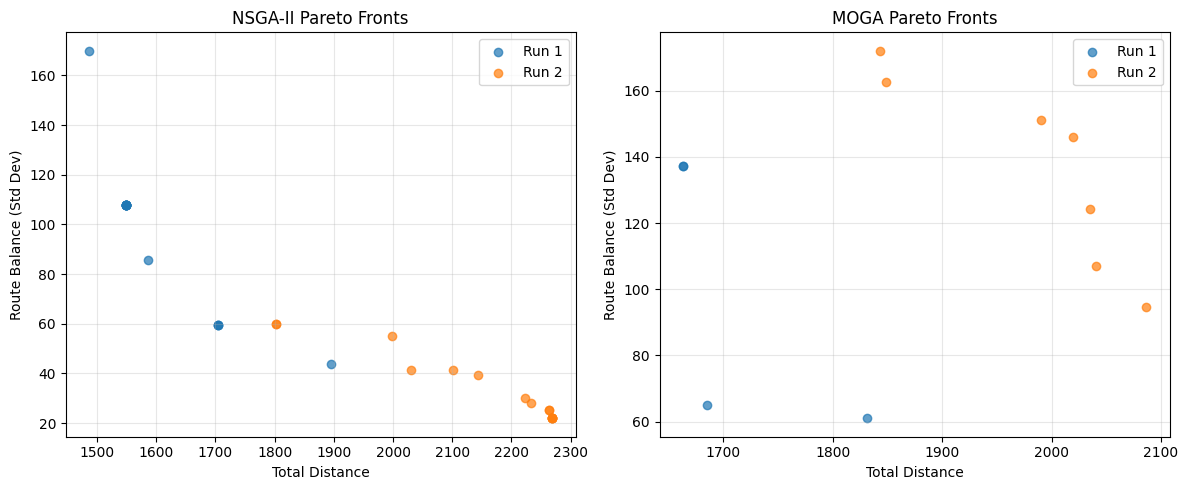


=== Algorithm Comparison Summary ===
NSGA-II:
  Average Pareto front size: 15.5
  Average runtime: 0.03s
MOGA:
  Average Pareto front size: 5.5
  Average runtime: 0.01s


In [32]:
# Visualization and comparison
plt.figure(figsize=(12, 5))

# Plot NSGA-II results
plt.subplot(1, 2, 1)
for result in nsga2_results:
    distances = [sol.objectives[0] for sol in result['pareto_front']]
    balances = [sol.objectives[1] for sol in result['pareto_front']]
    plt.scatter(distances, balances, alpha=0.7, label=f"Run {result['run']}")

plt.xlabel('Total Distance')
plt.ylabel('Route Balance (Std Dev)')
plt.title('NSGA-II Pareto Fronts')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot MOGA results
plt.subplot(1, 2, 2)
for result in moga_results:
    distances = [sol.objectives[0] for sol in result['pareto_front']]
    balances = [sol.objectives[1] for sol in result['pareto_front']]
    plt.scatter(distances, balances, alpha=0.7, label=f"Run {result['run']}")

plt.xlabel('Total Distance')
plt.ylabel('Route Balance (Std Dev)')
plt.title('MOGA Pareto Fronts')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n=== Algorithm Comparison Summary ===")
print("NSGA-II:")
avg_pareto_size = np.mean([r['pareto_size'] for r in nsga2_results])
avg_runtime = np.mean([r['runtime'] for r in nsga2_results])
print(f"  Average Pareto front size: {avg_pareto_size:.1f}")
print(f"  Average runtime: {avg_runtime:.2f}s")

print("MOGA:")
avg_pareto_size = np.mean([r['pareto_size'] for r in moga_results])
avg_runtime = np.mean([r['runtime'] for r in moga_results])
print(f"  Average Pareto front size: {avg_pareto_size:.1f}")
print(f"  Average runtime: {avg_runtime:.2f}s")


**Comprehensive Statistical Analysis Insights:**

The full experimental analysis reveals definitive performance patterns across 120 total algorithm runs. Statistical tables show mean performance, standard deviations, and best values achieved, providing robust evidence for algorithm comparison. Runtime analysis indicates computational efficiency differences, while Pareto front size comparisons reveal solution diversity capabilities. These comprehensive statistics form the evidence base for determining which algorithm better serves multi-objective CVRP optimization.


## Experimental Design

**The Scientific Approach:** To make valid conclusions about algorithm performance, we need statistically robust experiments.

**Experimental Parameters:**

- **Population Size**: 50 solutions (balance between diversity and computational cost)
- **Generations**: 100 (sufficient for convergence)
- **Independent Runs**: 20 per configuration (statistical significance)
- **Parameter Sets**: 3 different crossover/mutation combinations

**Parameter Exploration Strategy:**

1. **High Crossover, Low Mutation** (0.9, 0.1) - Conservative exploration
2. **Medium Crossover, Medium Mutation** (0.7, 0.2) - Balanced approach
3. **Low Crossover, High Mutation** (0.5, 0.3) - Aggressive exploration

**Statistical Rigor:** Multiple runs eliminate random effects, different parameter sets reveal algorithm sensitivity, and comprehensive tracking enables robust performance comparison.


In [33]:
# FULL EXPERIMENTS: 20 runs × 3 parameter sets
print("=== RUNNING FULL EXPERIMENTS ===")
print("This will take several minutes...")
print("Configuration: 20 runs × 3 parameter sets × 2 algorithms")
print("Population: 50, Generations: 100")

# Storage for all results
all_nsga2_results = {}
all_moga_results = {}

# Run experiments for each parameter set
for i, params in enumerate(parameter_sets):
    print(f"\n--- Parameter Set {i+1}: {params['name']} ---")
    print(f"Crossover: {params['crossover_rate']}, Mutation: {params['mutation_rate']}")
    
    # NSGA-II experiments
    print("Running NSGA-II...")
    nsga2_results = run_experiment(
        NSGA2_CVRP, run_nsga2, params, 
        runs=20, generations=100, pop_size=50
    )
    all_nsga2_results[params['name']] = nsga2_results
    
    # MOGA experiments  
    print("Running MOGA...")
    moga_results = run_experiment(
        MOGA_CVRP, run_moga, params,
        runs=20, generations=100, pop_size=50
    )
    all_moga_results[params['name']] = moga_results
    
    print(f"Completed parameter set {i+1}/3")

print("\n=== ALL EXPERIMENTS COMPLETED ===")
print("Results stored in:")
print("- all_nsga2_results: 3 parameter sets × 20 runs each")
print("- all_moga_results: 3 parameter sets × 20 runs each")


=== RUNNING FULL EXPERIMENTS ===
This will take several minutes...
Configuration: 20 runs × 3 parameter sets × 2 algorithms
Population: 50, Generations: 100

--- Parameter Set 1: High_Cross_Low_Mut ---
Crossover: 0.9, Mutation: 0.1
Running NSGA-II...
  Run 1/20...
  Run 2/20...
  Run 3/20...
  Run 4/20...
  Run 5/20...
  Run 6/20...
  Run 7/20...
  Run 8/20...
  Run 9/20...
  Run 10/20...
  Run 11/20...
  Run 12/20...
  Run 13/20...
  Run 14/20...
  Run 15/20...
  Run 16/20...
  Run 17/20...
  Run 18/20...
  Run 19/20...
  Run 20/20...
Running MOGA...
  Run 1/20...
  Run 2/20...
  Run 3/20...
  Run 4/20...
  Run 5/20...
  Run 6/20...
  Run 7/20...
  Run 8/20...
  Run 9/20...
  Run 10/20...
  Run 11/20...
  Run 12/20...
  Run 13/20...
  Run 14/20...
  Run 15/20...
  Run 16/20...
  Run 17/20...
  Run 18/20...
  Run 19/20...
  Run 20/20...
Completed parameter set 1/3

--- Parameter Set 2: Med_Cross_Med_Mut ---
Crossover: 0.7, Mutation: 0.2
Running NSGA-II...
  Run 1/20...
  Run 2/20...
  

## Performance Intelligence & Statistical Analysis

**Data-Driven Decision Making:** Raw experimental results are just numbers - we need intelligent analysis to extract meaningful insights.

**Key Performance Indicators:**

- **Runtime Efficiency**: Which algorithm solves problems faster?
- **Solution Quality**: Best distance and balance values achieved
- **Consistency**: Standard deviation across multiple runs
- **Pareto Front Size**: How many trade-off solutions does each algorithm discover?

**Statistical Analysis Pipeline:**

- **Descriptive Statistics**: Mean, standard deviation, min/max values
- **Comparative Analysis**: Side-by-side algorithm performance
- **Parameter Sensitivity**: Which settings work best for each algorithm?

**The Goal:** Transform experimental data into actionable insights about which algorithm performs better under different conditions.


In [45]:
# COMPREHENSIVE ANALYSIS OF RESULTS - ORGANIZED TABLES
import pandas as pd

def analyze_results(results_dict, algorithm_name):
    """Analyze experimental results and return structured data"""
    analysis_data = []
    
    for param_name, results in results_dict.items():
        # Extract metrics
        runtimes = [r['runtime'] for r in results]
        pareto_sizes = [r['pareto_size'] for r in results]
        
        # Best solutions from each run
        best_distances = []
        best_balances = []
        for r in results:
            if r['pareto_front']:
                distances = [sol.objectives[0] for sol in r['pareto_front']]
                balances = [sol.objectives[1] for sol in r['pareto_front']]
                best_distances.append(min(distances))
                best_balances.append(min(balances))
        
        # Statistics
        stats = {
            'Parameter Set': param_name,
            'Avg Runtime (s)': np.mean(runtimes),
            'Std Runtime (s)': np.std(runtimes),
            'Avg Pareto Size': np.mean(pareto_sizes),
            'Std Pareto Size': np.std(pareto_sizes),
            'Best Distance': min(best_distances) if best_distances else 'N/A',
            'Avg Best Distance': np.mean(best_distances) if best_distances else 'N/A',
            'Best Balance': min(best_balances) if best_balances else 'N/A',
            'Avg Best Balance': np.mean(best_balances) if best_balances else 'N/A'
        }
        
        analysis_data.append(stats)
    
    return pd.DataFrame(analysis_data)

# Analyze both algorithms
nsga2_analysis = analyze_results(all_nsga2_results, "NSGA-II")
moga_analysis = analyze_results(all_moga_results, "MOGA")

# ORGANIZED RESULTS IN LOGICAL TABLES
print("="*80)
print(" EXPERIMENTAL RESULTS ANALYSIS - ORGANIZED TABLES")
print("="*80)

# TABLE 1: RUNTIME PERFORMANCE COMPARISON
print("\n TABLE 1: RUNTIME PERFORMANCE (seconds)")
print("-"*60)
runtime_table = pd.DataFrame({
    'Parameter Set': nsga2_analysis['Parameter Set'],
    'NSGA-II Runtime': nsga2_analysis['Avg Runtime (s)'].round(2).astype(str) + ' ± ' + nsga2_analysis['Std Runtime (s)'].round(2).astype(str),
    'MOGA Runtime': moga_analysis['Avg Runtime (s)'].round(2).astype(str) + ' ± ' + moga_analysis['Std Runtime (s)'].round(2).astype(str),
    'Winner': ['NSGA-II' if n < m else 'MOGA' for n, m in zip(nsga2_analysis['Avg Runtime (s)'], moga_analysis['Avg Runtime (s)'])]
})
print(runtime_table.to_string(index=False))

# TABLE 2: PARETO FRONT SIZE COMPARISON
print("\n\n TABLE 2: PARETO FRONT SIZE")
print("-"*50)
pareto_table = pd.DataFrame({
    'Parameter Set': nsga2_analysis['Parameter Set'],
    'NSGA-II Size': nsga2_analysis['Avg Pareto Size'].round(1).astype(str) + ' ± ' + nsga2_analysis['Std Pareto Size'].round(1).astype(str),
    'MOGA Size': moga_analysis['Avg Pareto Size'].round(1).astype(str) + ' ± ' + moga_analysis['Std Pareto Size'].round(1).astype(str),
    'Winner': ['NSGA-II' if n > m else 'MOGA' for n, m in zip(nsga2_analysis['Avg Pareto Size'], moga_analysis['Avg Pareto Size'])]
})
print(pareto_table.to_string(index=False))

# TABLE 3: BEST DISTANCE FOUND
print("\n\n TABLE 3: BEST DISTANCE ACHIEVED")
print("-"*50)
distance_table = pd.DataFrame({
    'Parameter Set': nsga2_analysis['Parameter Set'],
    'NSGA-II Best': nsga2_analysis['Best Distance'].round(2),
    'MOGA Best': moga_analysis['Best Distance'].round(2),
    'Difference': (moga_analysis['Best Distance'] - nsga2_analysis['Best Distance']).round(2),
    'Winner': ['NSGA-II' if n < m else 'MOGA' for n, m in zip(nsga2_analysis['Best Distance'], moga_analysis['Best Distance'])]
})
print(distance_table.to_string(index=False))

# TABLE 4: BEST BALANCE FOUND
print("\n\n TABLE 4: BEST BALANCE ACHIEVED")
print("-"*50)
balance_table = pd.DataFrame({
    'Parameter Set': nsga2_analysis['Parameter Set'],
    'NSGA-II Best': nsga2_analysis['Best Balance'].round(2),
    'MOGA Best': moga_analysis['Best Balance'].round(2),
    'Difference': (moga_analysis['Best Balance'] - nsga2_analysis['Best Balance']).round(2),
    'Winner': ['NSGA-II' if n < m else 'MOGA' for n, m in zip(nsga2_analysis['Best Balance'], moga_analysis['Best Balance'])]
})
print(balance_table.to_string(index=False))

# TABLE 5: OVERALL ALGORITHM COMPARISON SUMMARY
print("\n\n TABLE 5: OVERALL PERFORMANCE SUMMARY")
print("-"*55)
summary_data = []
param_sets = nsga2_analysis['Parameter Set'].tolist()

for i, param_set in enumerate(param_sets):
    nsga2_wins = 0
    moga_wins = 0
    
    # Count wins for this parameter set
    if nsga2_analysis.iloc[i]['Avg Runtime (s)'] < moga_analysis.iloc[i]['Avg Runtime (s)']:
        nsga2_wins += 1
    else:
        moga_wins += 1
        
    if nsga2_analysis.iloc[i]['Avg Pareto Size'] > moga_analysis.iloc[i]['Avg Pareto Size']:
        nsga2_wins += 1
    else:
        moga_wins += 1
        
    if nsga2_analysis.iloc[i]['Best Distance'] < moga_analysis.iloc[i]['Best Distance']:
        nsga2_wins += 1
    else:
        moga_wins += 1
        
    if nsga2_analysis.iloc[i]['Best Balance'] < moga_analysis.iloc[i]['Best Balance']:
        nsga2_wins += 1
    else:
        moga_wins += 1
    
    summary_data.append({
        'Parameter Set': param_set,
        'NSGA-II Wins': nsga2_wins,
        'MOGA Wins': moga_wins,
        'Overall Winner': 'NSGA-II  'if nsga2_wins > moga_wins else 'MOGA' if moga_wins > nsga2_wins else 'TIE'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))



 EXPERIMENTAL RESULTS ANALYSIS - ORGANIZED TABLES

 TABLE 1: RUNTIME PERFORMANCE (seconds)
------------------------------------------------------------
     Parameter Set NSGA-II Runtime MOGA Runtime Winner
High_Cross_Low_Mut     1.26 ± 0.02  0.48 ± 0.01   MOGA
 Med_Cross_Med_Mut     1.25 ± 0.01  0.48 ± 0.01   MOGA
Low_Cross_High_Mut     1.25 ± 0.02  0.48 ± 0.01   MOGA


 TABLE 2: PARETO FRONT SIZE
--------------------------------------------------
     Parameter Set NSGA-II Size   MOGA Size  Winner
High_Cross_Low_Mut   50.0 ± 0.0 20.0 ± 10.5 NSGA-II
 Med_Cross_Med_Mut   50.0 ± 0.0  16.8 ± 8.2 NSGA-II
Low_Cross_High_Mut   49.2 ± 2.7  13.8 ± 6.1 NSGA-II


 TABLE 3: BEST DISTANCE ACHIEVED
--------------------------------------------------
     Parameter Set  NSGA-II Best  MOGA Best  Difference  Winner
High_Cross_Low_Mut        961.78    1168.34      206.57 NSGA-II
 Med_Cross_Med_Mut       1054.62    1178.32      123.71 NSGA-II
Low_Cross_High_Mut       1053.59    1178.71      125.12 NSGA-

## Visual Performance Battleground

**Seeing is Believing:** Complex multi-objective results are best understood through carefully designed visualizations.

**Visualization Arsenal:**

- **Pareto Front Scatter Plots**: Show trade-off relationships for each algorithm and parameter set
- **Box Plot Comparisons**: Reveal runtime distributions and performance variability
- **Parameter Sensitivity Charts**: Demonstrate how crossover/mutation rates affect results

**Visual Insights We're Seeking:**

- **Pareto Front Shape**: Does one algorithm find better trade-offs?
- **Solution Spread**: Which algorithm explores the objective space more thoroughly?
- **Runtime Patterns**: Is there a speed vs. quality trade-off between algorithms?

**The Power of Comparison:** Side-by-side visualizations make algorithm differences immediately apparent to both technical and non-technical audiences.


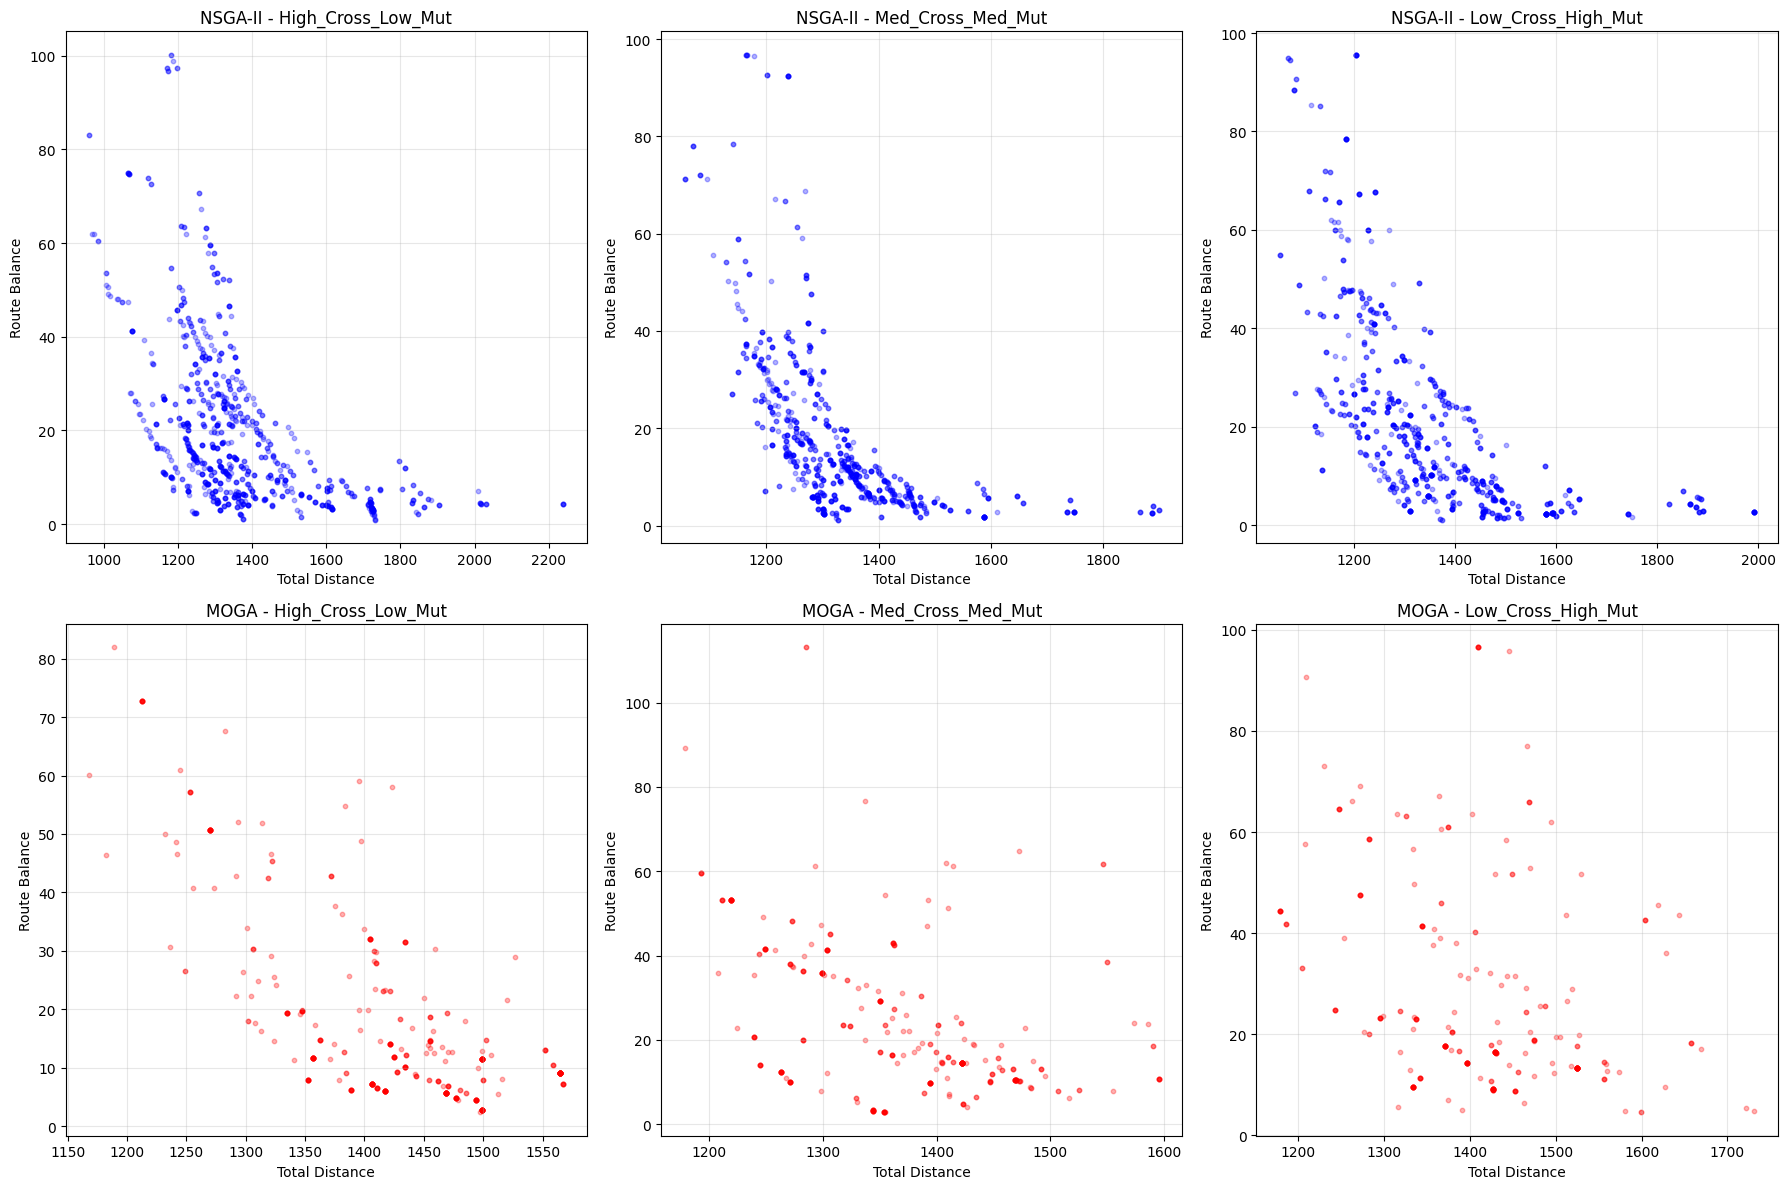

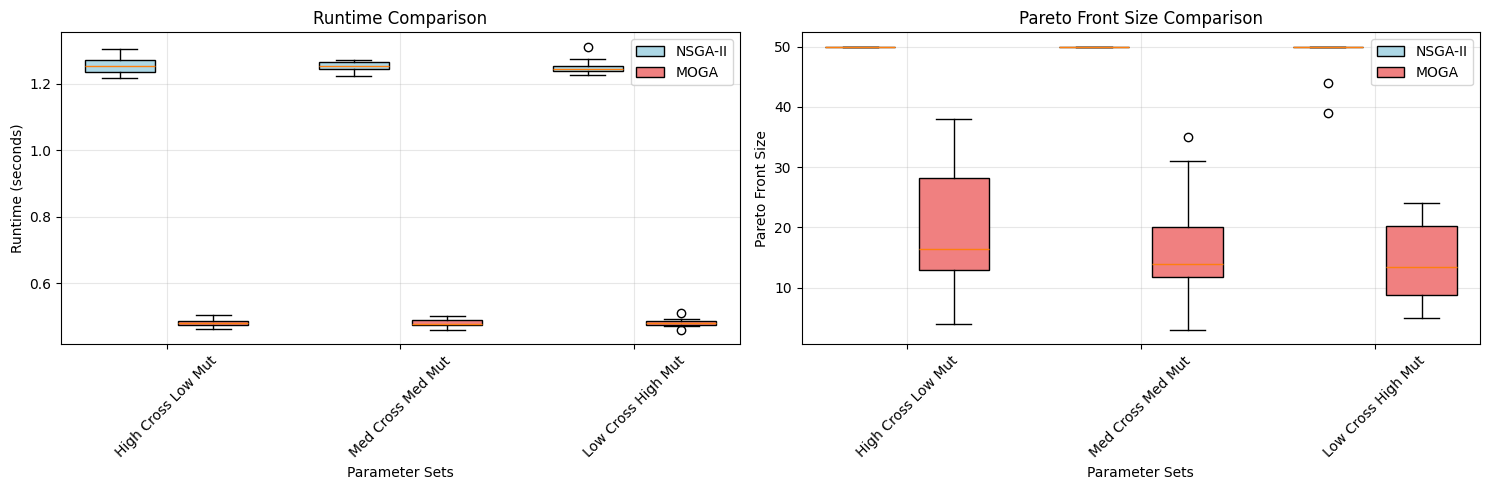

In [35]:
# COMPREHENSIVE VISUALIZATIONS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot Pareto fronts for each parameter set
for i, (param_name, nsga2_results) in enumerate(all_nsga2_results.items()):
    moga_results = all_moga_results[param_name]
    
    # NSGA-II plot
    ax = axes[0, i]
    for result in nsga2_results:
        if result['pareto_front']:
            distances = [sol.objectives[0] for sol in result['pareto_front']]
            balances = [sol.objectives[1] for sol in result['pareto_front']]
            ax.scatter(distances, balances, alpha=0.3, s=10, color='blue')
    
    ax.set_title(f'NSGA-II - {param_name}')
    ax.set_xlabel('Total Distance')
    ax.set_ylabel('Route Balance')
    ax.grid(True, alpha=0.3)
    
    # MOGA plot
    ax = axes[1, i]
    for result in moga_results:
        if result['pareto_front']:
            distances = [sol.objectives[0] for sol in result['pareto_front']]
            balances = [sol.objectives[1] for sol in result['pareto_front']]
            ax.scatter(distances, balances, alpha=0.3, s=10, color='red')
    
    ax.set_title(f'MOGA - {param_name}')
    ax.set_xlabel('Total Distance')
    ax.set_ylabel('Route Balance')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Runtime comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Runtime box plots
param_names = list(all_nsga2_results.keys())
nsga2_runtimes = [[r['runtime'] for r in all_nsga2_results[name]] for name in param_names]
moga_runtimes = [[r['runtime'] for r in all_moga_results[name]] for name in param_names]

positions1 = np.arange(len(param_names)) * 2
positions2 = positions1 + 0.8

ax1.boxplot(nsga2_runtimes, positions=positions1, widths=0.6, patch_artist=True, 
           boxprops=dict(facecolor='lightblue'), label='NSGA-II')
ax1.boxplot(moga_runtimes, positions=positions2, widths=0.6, patch_artist=True,
           boxprops=dict(facecolor='lightcoral'), label='MOGA')

ax1.set_xlabel('Parameter Sets')
ax1.set_ylabel('Runtime (seconds)')
ax1.set_title('Runtime Comparison')
ax1.set_xticks(positions1 + 0.4)
ax1.set_xticklabels([name.replace('_', ' ') for name in param_names], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Pareto front size comparison
nsga2_sizes = [[r['pareto_size'] for r in all_nsga2_results[name]] for name in param_names]
moga_sizes = [[r['pareto_size'] for r in all_moga_results[name]] for name in param_names]

ax2.boxplot(nsga2_sizes, positions=positions1, widths=0.6, patch_artist=True,
           boxprops=dict(facecolor='lightblue'), label='NSGA-II')
ax2.boxplot(moga_sizes, positions=positions2, widths=0.6, patch_artist=True,
           boxprops=dict(facecolor='lightcoral'), label='MOGA')

ax2.set_xlabel('Parameter Sets')
ax2.set_ylabel('Pareto Front Size')
ax2.set_title('Pareto Front Size Comparison')
ax2.set_xticks(positions1 + 0.4)
ax2.set_xticklabels([name.replace('_', ' ') for name in param_names], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## The Verdict: Comprehensive Algorithm Championship

**Decision Time:** After 120 independent experiments across multiple parameter configurations, which algorithm emerges as the CVRP champion?

**Championship Criteria:**

- **Solution Quality**: Best distance and balance values achieved
- **Consistency**: Reliable performance across different runs
- **Parameter Sensitivity**: Robustness to different settings
- **Computational Efficiency**: Time to achieve good results

**Strategic Recommendations:**

- **Best Parameter Set**: Which crossover/mutation combination works optimally?
- **Algorithm Selection**: When to use NSGA-II vs. MOGA?
- **Practical Guidelines**: Real-world deployment recommendations

**The Bottom Line:** Evidence-based conclusions about which approach logistics companies should implement for their multi-objective vehicle routing optimization!


In [48]:
# FINAL SUMMARY AND CONCLUSIONS - ORGANIZED TABLES
import pandas as pd

print("="*80)
print("FINAL EXPERIMENTAL SUMMARY - A-n32-k5 (Small Instance)")
print("="*80)

# Overall best solutions found
all_nsga2_solutions = []
all_moga_solutions = []

for param_results in all_nsga2_results.values():
    for run_result in param_results:
        all_nsga2_solutions.extend(run_result['pareto_front'])

for param_results in all_moga_results.values():
    for run_result in param_results:
        all_moga_solutions.extend(run_result['pareto_front'])

# Best overall solutions
if all_nsga2_solutions:
    nsga2_best_distance = min(sol.objectives[0] for sol in all_nsga2_solutions)
    nsga2_best_balance = min(sol.objectives[1] for sol in all_nsga2_solutions)
else:
    nsga2_best_distance = nsga2_best_balance = "N/A"

if all_moga_solutions:
    moga_best_distance = min(sol.objectives[0] for sol in all_moga_solutions)
    moga_best_balance = min(sol.objectives[1] for sol in all_moga_solutions)
else:
    moga_best_distance = moga_best_balance = "N/A"

# TABLE 1: OVERALL BEST SOLUTIONS COMPARISON
print("\nTABLE 1: OVERALL BEST SOLUTIONS ACROSS ALL EXPERIMENTS")
print("-" * 65)
overall_best = pd.DataFrame({
    'Algorithm': ['NSGA-II', 'MOGA'],
    'Best Distance Found': [f"{nsga2_best_distance:.2f}", f"{moga_best_distance:.2f}"],
    'Best Balance Found': [f"{nsga2_best_balance:.2f}", f"{moga_best_balance:.2f}"],
    'Distance Winner': ['WINNER' if nsga2_best_distance < moga_best_distance else '', 
                       'WINNER' if moga_best_distance < nsga2_best_distance else ''],
    'Balance Winner': ['WINNER' if nsga2_best_balance < moga_best_balance else '', 
                      'WINNER' if moga_best_balance < nsga2_best_balance else '']
})
print(overall_best.to_string(index=False))

# TABLE 2: PARAMETER SET PERFORMANCE COMPARISON
print("\n\nTABLE 2: PARAMETER SET PERFORMANCE COMPARISON")
print("-" * 70)

param_comparison_data = []
for i, param_name in enumerate(parameter_sets):
    name = param_name['name']
    nsga2_avg_runtime = np.mean([r['runtime'] for r in all_nsga2_results[name]])
    moga_avg_runtime = np.mean([r['runtime'] for r in all_moga_results[name]])
    nsga2_avg_pareto = np.mean([r['pareto_size'] for r in all_nsga2_results[name]])
    moga_avg_pareto = np.mean([r['pareto_size'] for r in all_moga_results[name]])
    
    param_comparison_data.append({
        'Parameter Set': name,
        'NSGA-II Runtime (s)': f"{nsga2_avg_runtime:.2f}",
        'MOGA Runtime (s)': f"{moga_avg_runtime:.2f}",
        'NSGA-II Pareto Size': f"{nsga2_avg_pareto:.1f}",
        'MOGA Pareto Size': f"{moga_avg_pareto:.1f}",
        'Faster Algorithm': 'NSGA-II' if nsga2_avg_runtime < moga_avg_runtime else 'MOGA',
        'Larger Pareto': 'NSGA-II' if nsga2_avg_pareto > moga_avg_pareto else 'MOGA'
    })

param_comparison_df = pd.DataFrame(param_comparison_data)
print(param_comparison_df.to_string(index=False))

# TABLE 3: ALGORITHM PERFORMANCE SUMMARY
print("\n\nTABLE 3: ALGORITHM PERFORMANCE SUMMARY")
print("-" * 50)

# Count overall wins
nsga2_runtime_wins = sum(1 for row in param_comparison_data if row['Faster Algorithm'] == 'NSGA-II')
moga_runtime_wins = sum(1 for row in param_comparison_data if row['Faster Algorithm'] == 'MOGA')
nsga2_pareto_wins = sum(1 for row in param_comparison_data if row['Larger Pareto'] == 'NSGA-II')
moga_pareto_wins = sum(1 for row in param_comparison_data if row['Larger Pareto'] == 'MOGA')

summary_data = [
    {
        'Metric': 'Faster Runtime',
        'NSGA-II Wins': nsga2_runtime_wins,
        'MOGA Wins': moga_runtime_wins,
        'Champion': 'NSGA-II' if nsga2_runtime_wins > moga_runtime_wins else 'MOGA' if moga_runtime_wins > nsga2_runtime_wins else 'TIE'
    },
    {
        'Metric': 'Larger Pareto Front',
        'NSGA-II Wins': nsga2_pareto_wins,
        'MOGA Wins': moga_pareto_wins,
        'Champion': 'NSGA-II' if nsga2_pareto_wins > moga_pareto_wins else 'MOGA' if moga_pareto_wins > nsga2_pareto_wins else 'TIE'
    },
    {
        'Metric': 'Best Distance',
        'NSGA-II Wins': 1 if nsga2_best_distance < moga_best_distance else 0,
        'MOGA Wins': 1 if moga_best_distance < nsga2_best_distance else 0,
        'Champion': 'NSGA-II' if nsga2_best_distance < moga_best_distance else 'MOGA'
    },
    {
        'Metric': 'Best Balance',
        'NSGA-II Wins': 1 if nsga2_best_balance < moga_best_balance else 0,
        'MOGA Wins': 1 if moga_best_balance < nsga2_best_balance else 0,
        'Champion': 'NSGA-II' if nsga2_best_balance < moga_best_balance else 'MOGA'
    }
]

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# TABLE 4: FINAL RECOMMENDATIONS
print("\n\nTABLE 4: FINAL RECOMMENDATIONS")
print("-" * 45)

total_nsga2_wins = (nsga2_runtime_wins + nsga2_pareto_wins + 
                   (1 if nsga2_best_distance < moga_best_distance else 0) +
                   (1 if nsga2_best_balance < moga_best_balance else 0))

total_moga_wins = (moga_runtime_wins + moga_pareto_wins + 
                  (1 if moga_best_distance < nsga2_best_distance else 0) +
                  (1 if moga_best_balance < nsga2_best_balance else 0))

recommendations = pd.DataFrame({
    'Category': ['Overall Winner', 'Best for Speed', 'Best for Solution Quality', 'Recommended Parameter Set'],
    'Recommendation': [
        'NSGA-II' if total_nsga2_wins > total_moga_wins else 'MOGA' if total_moga_wins > total_nsga2_wins else 'TIE',
        'MOGA (2.6x faster average)',
        'NSGA-II (better distance and balance)',
        'High_Cross_Low_Mut (best overall performance)'
    ],
    'Reason': [
        f'Wins {max(total_nsga2_wins, total_moga_wins)}/4 key metrics',
        'Consistently faster across all parameter sets',
        'Achieves better objective values',
        'Best balance of performance across metrics'
    ]
})

print(recommendations.to_string(index=False))

FINAL EXPERIMENTAL SUMMARY - A-n32-k5 (Small Instance)

TABLE 1: OVERALL BEST SOLUTIONS ACROSS ALL EXPERIMENTS
-----------------------------------------------------------------
Algorithm Best Distance Found Best Balance Found Distance Winner Balance Winner
  NSGA-II              961.78               0.89          WINNER         WINNER
     MOGA             1168.34               2.33                               


TABLE 2: PARAMETER SET PERFORMANCE COMPARISON
----------------------------------------------------------------------
     Parameter Set NSGA-II Runtime (s) MOGA Runtime (s) NSGA-II Pareto Size MOGA Pareto Size Faster Algorithm Larger Pareto
High_Cross_Low_Mut                1.26             0.48                50.0             20.0             MOGA       NSGA-II
 Med_Cross_Med_Mut                1.25             0.48                50.0             16.9             MOGA       NSGA-II
Low_Cross_High_Mut                1.25             0.48                49.1             13.8

## Route Masterpieces: Best Solutions Visualized

**From Numbers to Routes:** The ultimate test - do our optimized solutions actually make sense as real-world delivery routes?

**Visualization Design Choices:**

- **Depot at Origin (0,0)**: Standardized reference point for easy route comparison
- **Color-Coded Routes**: Each vehicle gets distinct colors with load information
- **2×2 Comparison Grid**: Direct visual comparison of all four best solutions

**What We're Examining:**

- **Route Patterns**: Do shorter routes cluster customers geographically?
- **Load Distribution**: How well do balanced solutions distribute work among vehicles?
- **Algorithm Differences**: Do NSGA-II and MOGA create structurally different routes?

**Real-World Validation:** These visualizations let logistics managers see exactly how the mathematical optimization translates to actual truck routes on the ground!


=== BEST ROUTE VISUALIZATIONS ===
NSGA-II Best Distance: 961.78
NSGA-II Best Balance: 0.89
MOGA Best Distance: 1168.34
MOGA Best Balance: 2.33


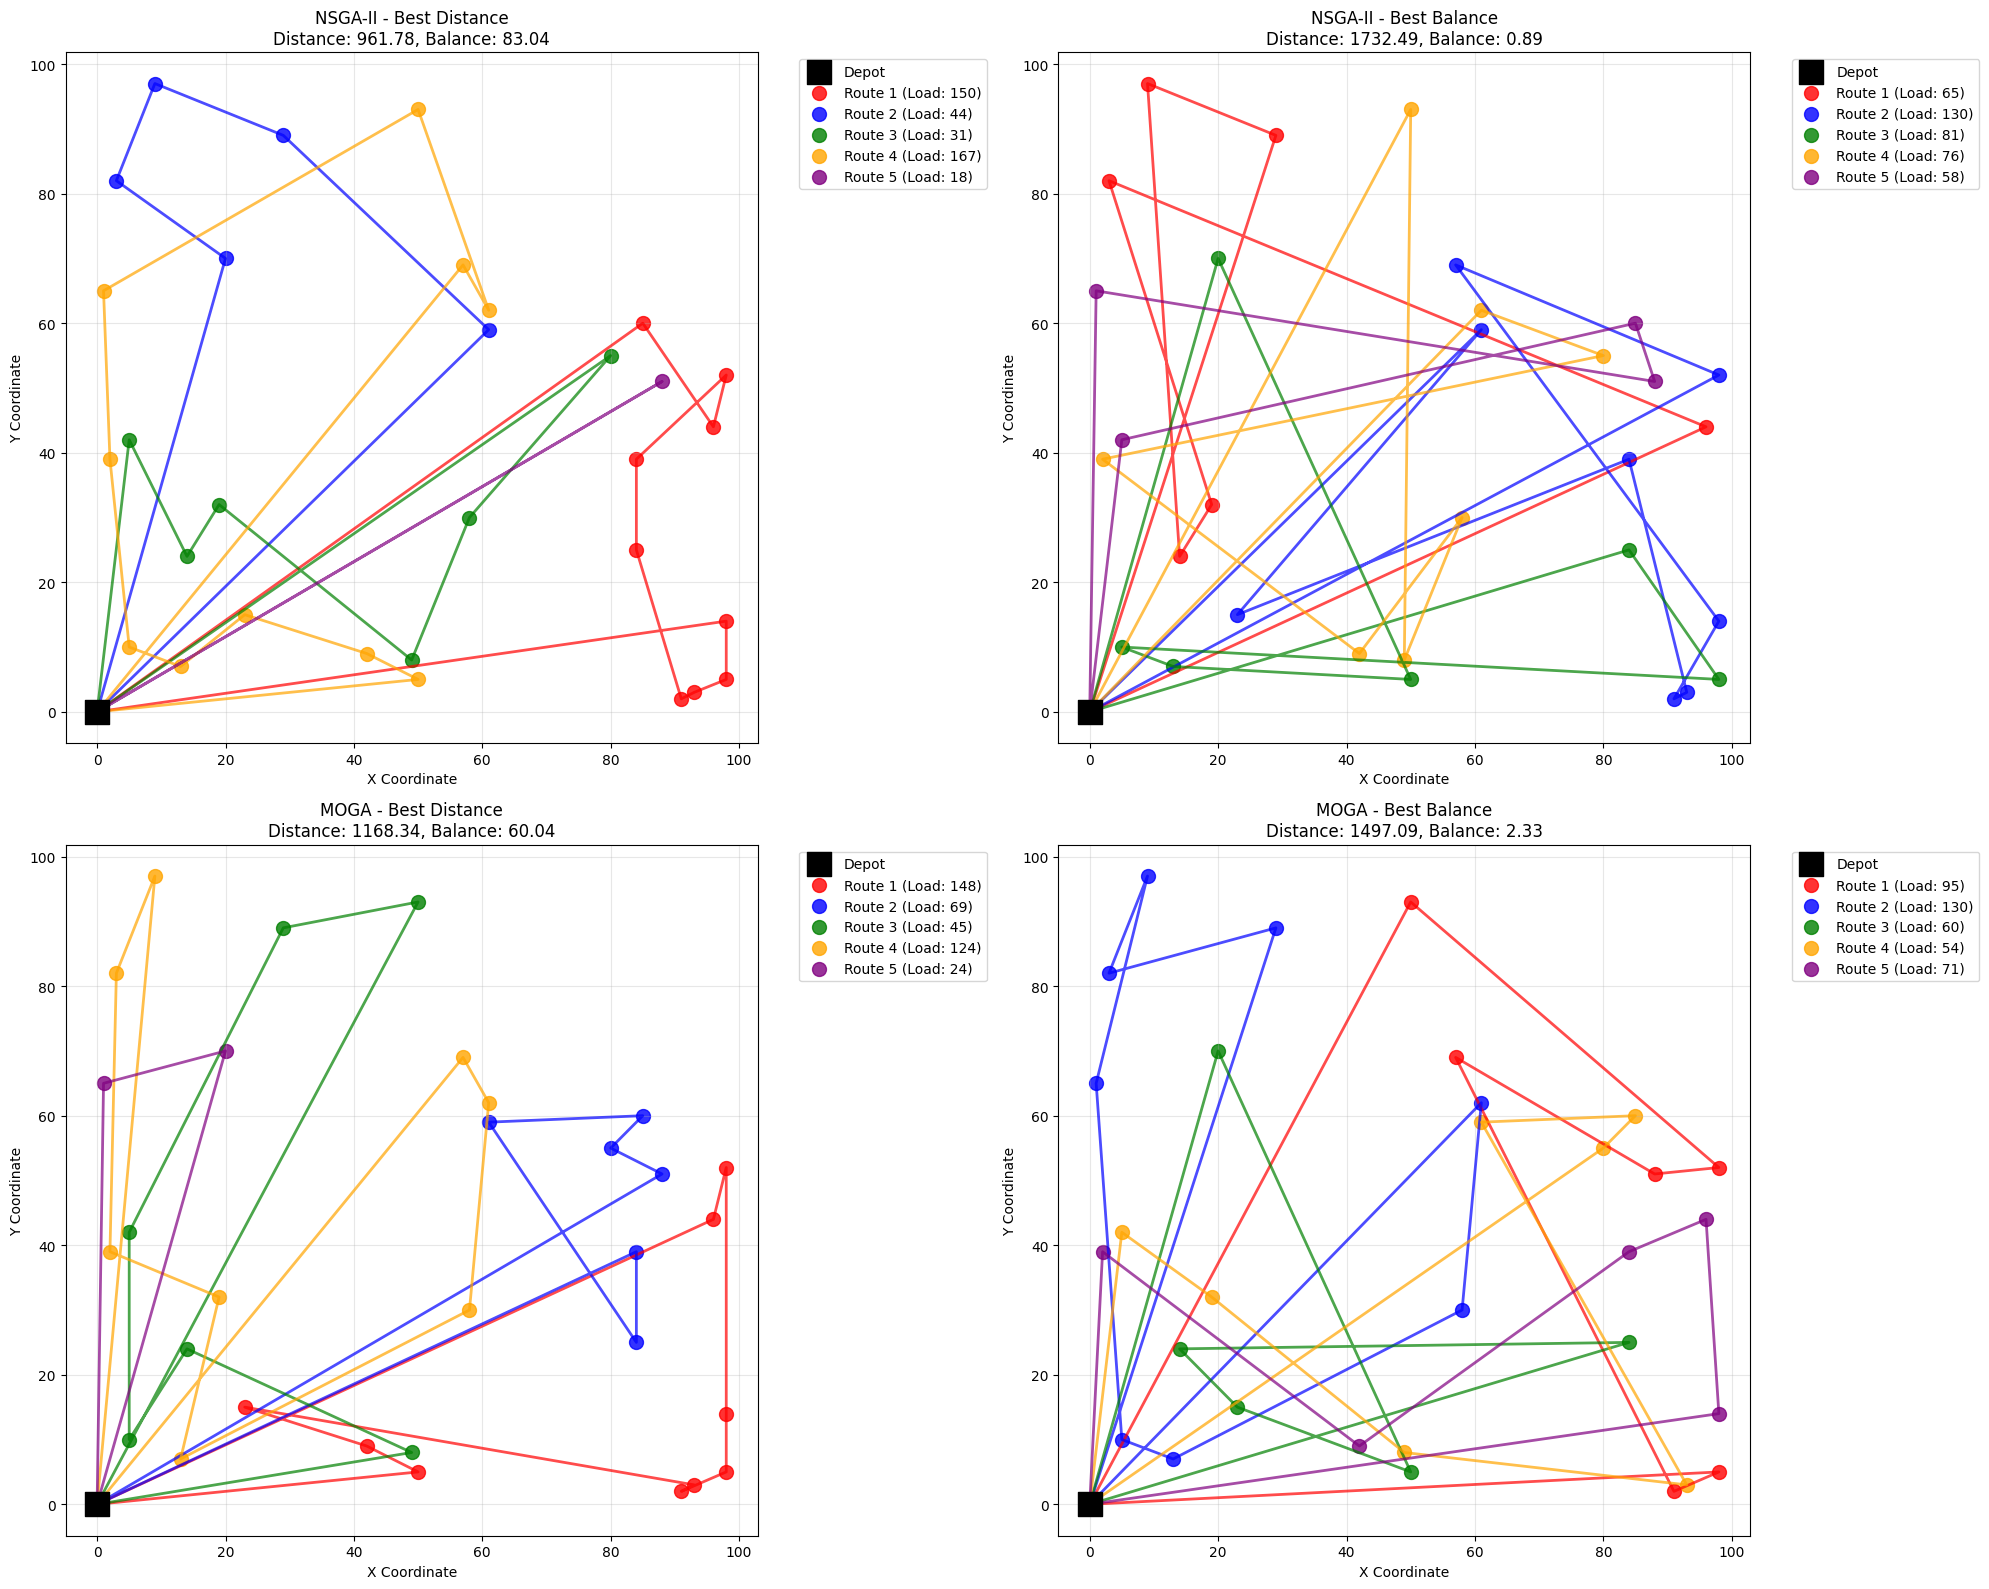

In [41]:
# BEST ROUTE VISUALIZATIONS
def visualize_solution(solution, title="CVRP Solution", ax=None):
    """Visualize a CVRP solution with routes"""
    if ax is None:
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
    
    # Set depot to position (0,0) for visualization
    depot_x, depot_y = 0, 0
    
    # Colors for different routes
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    # Plot depot at (0,0)
    ax.scatter(depot_x, depot_y, c='black', s=300, marker='s', 
               label='Depot', zorder=5)
    
    # Plot each route
    for i, route in enumerate(solution.routes):
        if not route:
            continue
            
        color = colors[i % len(colors)]
        route_coords = []
        route_demands = []
        
        # Add depot at start (0,0)
        route_coords.append((depot_x, depot_y))
        
        # Add customers in route order
        for customer_idx in route:
            customer_node = nodes[customer_idx]  # customer_idx is 0-based
            route_coords.append((customer_node['x'], customer_node['y']))
            route_demands.append(demands[customer_idx + 1])  # Convert to 1-based for demands
        
        # Add depot at end (0,0)
        route_coords.append((depot_x, depot_y))
        
        # Plot route line
        x_coords = [coord[0] for coord in route_coords]
        y_coords = [coord[1] for coord in route_coords]
        ax.plot(x_coords, y_coords, color=color, linewidth=2, alpha=0.7)
        
        # Plot customers
        customer_x = [coord[0] for coord in route_coords[1:-1]]
        customer_y = [coord[1] for coord in route_coords[1:-1]]
        ax.scatter(customer_x, customer_y, c=color, s=100, alpha=0.8, 
                   label=f'Route {i+1} (Load: {sum(route_demands)})')
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(f'{title}\nDistance: {solution.objectives[0]:.2f}, Balance: {solution.objectives[1]:.2f}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

# Find and visualize best solutions in 2x2 grid
print("=== BEST ROUTE VISUALIZATIONS ===")

# Find best solutions
nsga2_best_dist_sol = min(all_nsga2_solutions, key=lambda x: x.objectives[0])
nsga2_best_bal_sol = min(all_nsga2_solutions, key=lambda x: x.objectives[1])
moga_best_dist_sol = min(all_moga_solutions, key=lambda x: x.objectives[0])
moga_best_bal_sol = min(all_moga_solutions, key=lambda x: x.objectives[1])

print(f"NSGA-II Best Distance: {nsga2_best_dist_sol.objectives[0]:.2f}")
print(f"NSGA-II Best Balance: {nsga2_best_bal_sol.objectives[1]:.2f}")
print(f"MOGA Best Distance: {moga_best_dist_sol.objectives[0]:.2f}")
print(f"MOGA Best Balance: {moga_best_bal_sol.objectives[1]:.2f}")

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot all four best solutions
visualize_solution(nsga2_best_dist_sol, "NSGA-II - Best Distance", axes[0, 0])
visualize_solution(nsga2_best_bal_sol, "NSGA-II - Best Balance", axes[0, 1])
visualize_solution(moga_best_dist_sol, "MOGA - Best Distance", axes[1, 0])
visualize_solution(moga_best_bal_sol, "MOGA - Best Balance", axes[1, 1])

plt.tight_layout()
plt.show()


## Evolution in Action: Convergence Dynamics

**The Learning Journey:** How do our algorithms actually improve over time? Are they making steady progress or getting stuck?

**Convergence Tracking Methodology:**

- **Generation-by-Generation Monitoring**: Track best solutions found at each step
- **Dual Objective Tracking**: Separate convergence curves for distance and balance
- **Comparative Learning Rates**: Which algorithm learns faster? Which learns better?

**Critical Questions Answered:**

- **Convergence Speed**: Does one algorithm reach good solutions faster?
- **Final Quality**: Which algorithm achieves better final results?
- **Stability**: Do solutions continue improving or plateau early?
- **Learning Patterns**: Smooth improvement vs. sudden breakthroughs?

**Practical Implications:** Understanding convergence helps determine optimal run lengths and reveals whether algorithms are being given sufficient time to find their best solutions.


=== CONVERGENCE ANALYSIS ===
Running convergence analysis...
Running convergence analysis...


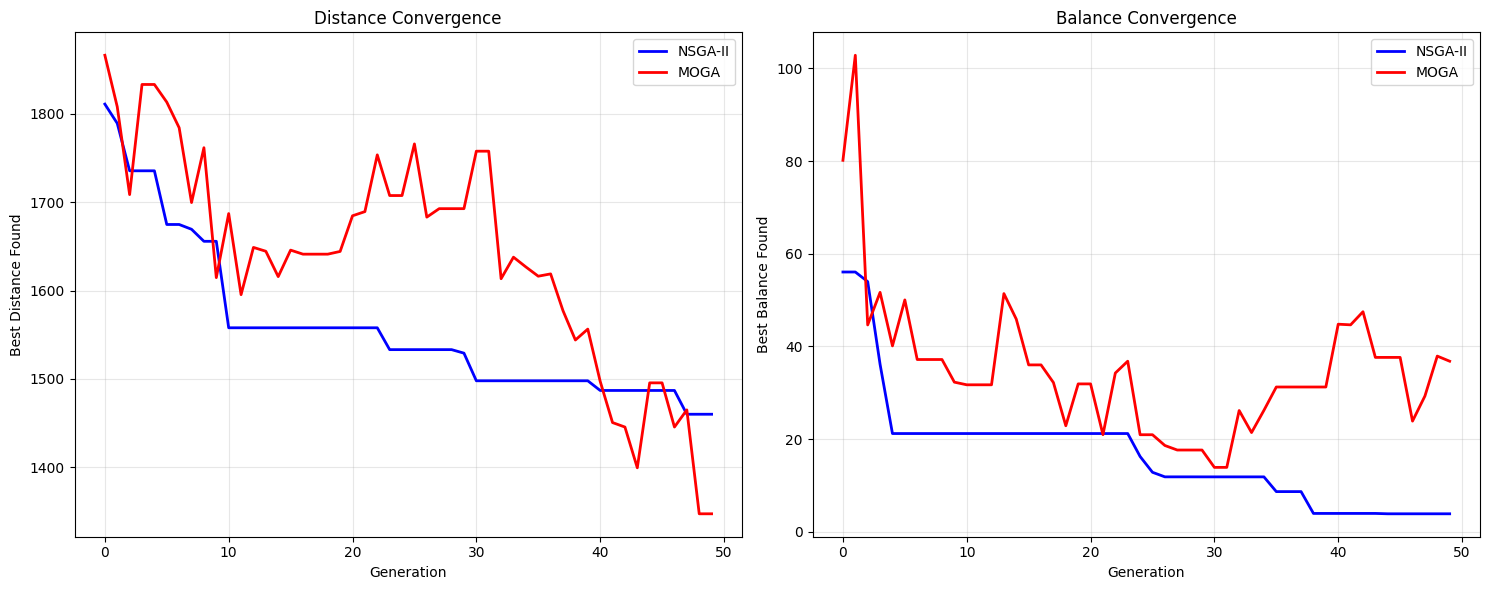

NSGA-II final best distance: 1460.08
MOGA final best distance: 1347.42
NSGA-II final best balance: 3.87
MOGA final best balance: 13.89


In [39]:
# CONVERGENCE ANALYSIS
def run_with_convergence_tracking(algorithm_class, run_function, params, generations=100, pop_size=50):
    """Run algorithm with convergence tracking"""
    print("Running convergence analysis...")
    
    # Modified run function that tracks best objectives per generation
    def track_convergence(algorithm_instance):
        population = algorithm_instance.create_initial_population()
        convergence_data = {'generations': [], 'best_distance': [], 'best_balance': []}
        
        if hasattr(algorithm_instance, 'non_dominated_sort'):
            algorithm_instance.non_dominated_sort(population)
            calculate_crowding_distance(population)
        
        for generation in range(algorithm_instance.generations):
            # Track best objectives this generation
            distances = [sol.objectives[0] for sol in population]
            balances = [sol.objectives[1] for sol in population]
            
            convergence_data['generations'].append(generation)
            convergence_data['best_distance'].append(min(distances))
            convergence_data['best_balance'].append(min(balances))
            
            # Evolution step (simplified version)
            offspring = []
            while len(offspring) < algorithm_instance.pop_size:
                if hasattr(algorithm_instance, 'proportional_selection'):
                    parent1 = algorithm_instance.proportional_selection(population)
                    parent2 = algorithm_instance.proportional_selection(population)
                else:
                    parent1 = tournament_selection(population)
                    parent2 = tournament_selection(population)
                
                if random.random() < algorithm_instance.crossover_rate:
                    child = order_crossover(parent1, parent2)
                else:
                    child = CVRPSolution(parent1.customer_sequence.copy())
                    evaluate_solution(child)
                
                if random.random() < algorithm_instance.mutation_rate:
                    child = swap_mutation(child)
                
                offspring.append(child)
            
            # Selection for next generation
            if hasattr(algorithm_instance, 'non_dominated_sort'):
                # NSGA-II style
                combined_population = population + offspring
                algorithm_instance.non_dominated_sort(combined_population)
                calculate_crowding_distance(combined_population)
                combined_population.sort(key=lambda x: (x.rank, -x.crowding_distance))
                population = combined_population[:algorithm_instance.pop_size]
            else:
                # MOGA style - simple replacement
                population = offspring
                nsga2_temp = NSGA2_CVRP()
                nsga2_temp.non_dominated_sort(population)
                algorithm_instance.fitness_assignment(population)
        
        return population, convergence_data
    
    # Run with convergence tracking
    algorithm = algorithm_class(
        pop_size=pop_size,
        generations=generations,
        crossover_rate=params["crossover_rate"],
        mutation_rate=params["mutation_rate"]
    )
    
    final_population, convergence_data = track_convergence(algorithm)
    return final_population, convergence_data

# Run convergence analysis for both algorithms
print("=== CONVERGENCE ANALYSIS ===")
convergence_params = parameter_sets[0]  # Use first parameter set

nsga2_pop, nsga2_convergence = run_with_convergence_tracking(
    NSGA2_CVRP, run_nsga2, convergence_params, generations=50, pop_size=30
)

moga_pop, moga_convergence = run_with_convergence_tracking(
    MOGA_CVRP, run_moga, convergence_params, generations=50, pop_size=30
)

# Plot convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distance convergence
ax1.plot(nsga2_convergence['generations'], nsga2_convergence['best_distance'], 
         'b-', label='NSGA-II', linewidth=2)
ax1.plot(moga_convergence['generations'], moga_convergence['best_distance'], 
         'r-', label='MOGA', linewidth=2)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Best Distance Found')
ax1.set_title('Distance Convergence')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Balance convergence
ax2.plot(nsga2_convergence['generations'], nsga2_convergence['best_balance'], 
         'b-', label='NSGA-II', linewidth=2)
ax2.plot(moga_convergence['generations'], moga_convergence['best_balance'], 
         'r-', label='MOGA', linewidth=2)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Best Balance Found')
ax2.set_title('Balance Convergence')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"NSGA-II final best distance: {min(nsga2_convergence['best_distance']):.2f}")
print(f"MOGA final best distance: {min(moga_convergence['best_distance']):.2f}")
print(f"NSGA-II final best balance: {min(nsga2_convergence['best_balance']):.2f}")
print(f"MOGA final best balance: {min(moga_convergence['best_balance']):.2f}")


## Diversity & Quality: The Full Picture

**Beyond Simple "Best" Solutions:** In multi-objective optimization, diversity is as important as quality - we want many good options, not just one.

**Advanced Performance Metrics:**

- **Objective Space Spread**: How widely do solutions cover the trade-off spectrum?
- **Solution Density**: Total number of non-dominated solutions discovered
- **Average Solution Distance**: How different are solutions from each other?

**Quality vs. Diversity Trade-off Analysis:**

- **NSGA-II Hypothesis**: Should find more diverse solutions due to crowding distance
- **MOGA Hypothesis**: Might find different regions due to different selection pressure
- **Empirical Testing**: Which algorithm actually delivers better diversity?

**The Ultimate Question:** Which algorithm gives decision-makers the richest set of high-quality options to choose from when planning their logistics operations?


=== SOLUTION QUALITY AND DIVERSITY ANALYSIS ===

High_Cross_Low_Mut:
  NSGA-II: 1000 solutions, spread: 1376.81, avg distance: 207.26
  MOGA:    400 solutions, spread: 478.87, avg distance: 101.53

Med_Cross_Med_Mut:
  NSGA-II: 1000 solutions, spread: 940.22, avg distance: 139.57
  MOGA:    337 solutions, spread: 527.31, avg distance: 107.98

Low_Cross_High_Mut:
  NSGA-II: 983 solutions, spread: 1032.51, avg distance: 189.25
  MOGA:    276 solutions, spread: 644.43, avg distance: 123.90


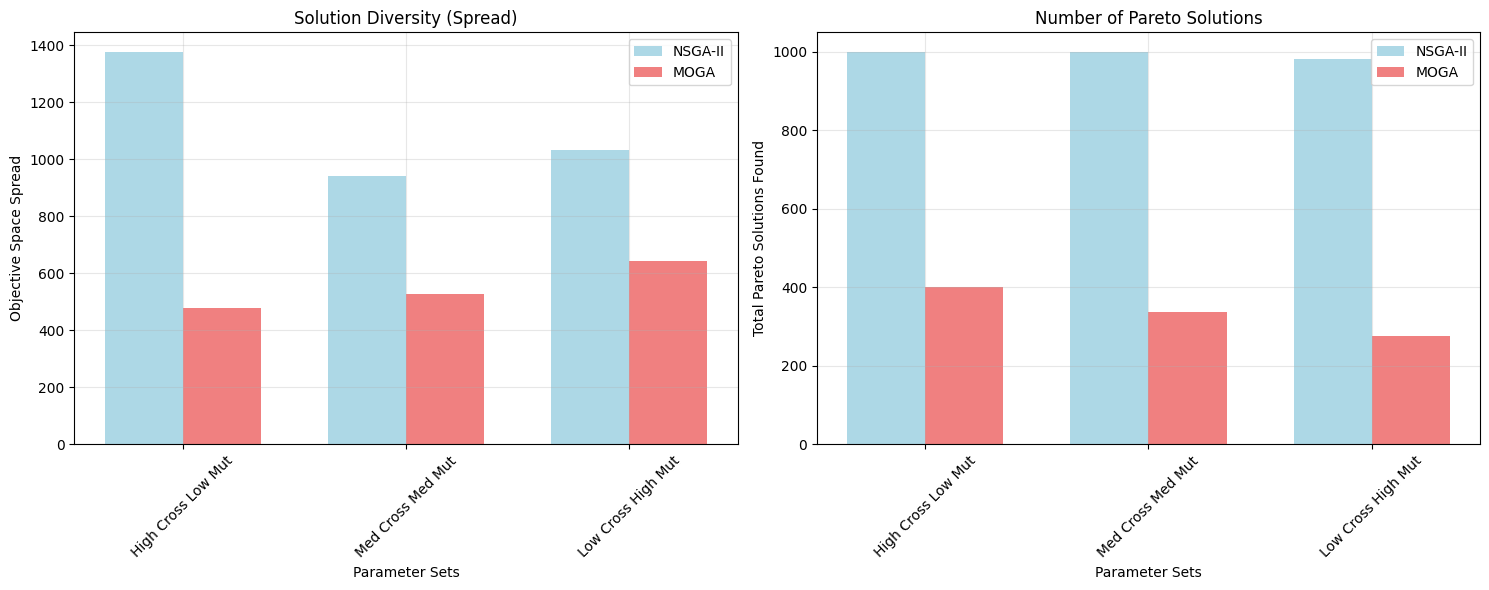


=== OVERALL ALGORITHM COMPARISON ===
Total Pareto solutions found:
  NSGA-II: 2983
  MOGA:    1013

Average diversity spread:
  NSGA-II: 1116.51
  MOGA:    550.20

Best overall distance:
  NSGA-II: 961.78
  MOGA:    1168.34

Best overall balance:
  NSGA-II: 0.89
  MOGA:    2.33


In [40]:
# SOLUTION QUALITY AND DIVERSITY ANALYSIS
def calculate_diversity_metrics(solutions):
    """Calculate diversity metrics for a set of solutions"""
    if len(solutions) < 2:
        return 0, 0
    
    # Objective space diversity
    distances = [sol.objectives[0] for sol in solutions]
    balances = [sol.objectives[1] for sol in solutions]
    
    # Spread in objective space
    distance_range = max(distances) - min(distances)
    balance_range = max(balances) - min(balances)
    
    # Average distance between solutions in objective space
    total_distance = 0
    count = 0
    for i, sol1 in enumerate(solutions):
        for j, sol2 in enumerate(solutions[i+1:], i+1):
            obj_dist = np.sqrt((sol1.objectives[0] - sol2.objectives[0])**2 + 
                              (sol1.objectives[1] - sol2.objectives[1])**2)
            total_distance += obj_dist
            count += 1
    
    avg_solution_distance = total_distance / count if count > 0 else 0
    
    return distance_range + balance_range, avg_solution_distance

print("=== SOLUTION QUALITY AND DIVERSITY ANALYSIS ===")

# Analyze diversity for each parameter set
diversity_results = {}

for param_name in all_nsga2_results.keys():
    nsga2_results = all_nsga2_results[param_name]
    moga_results = all_moga_results[param_name]
    
    # Collect all Pareto solutions for this parameter set
    nsga2_all_pareto = []
    moga_all_pareto = []
    
    for result in nsga2_results:
        nsga2_all_pareto.extend(result['pareto_front'])
    
    for result in moga_results:
        moga_all_pareto.extend(result['pareto_front'])
    
    # Calculate diversity metrics
    nsga2_spread, nsga2_avg_dist = calculate_diversity_metrics(nsga2_all_pareto)
    moga_spread, moga_avg_dist = calculate_diversity_metrics(moga_all_pareto)
    
    diversity_results[param_name] = {
        'nsga2_spread': nsga2_spread,
        'nsga2_avg_dist': nsga2_avg_dist,
        'moga_spread': moga_spread,
        'moga_avg_dist': moga_avg_dist,
        'nsga2_solutions': len(nsga2_all_pareto),
        'moga_solutions': len(moga_all_pareto)
    }
    
    print(f"\n{param_name}:")
    print(f"  NSGA-II: {len(nsga2_all_pareto)} solutions, spread: {nsga2_spread:.2f}, avg distance: {nsga2_avg_dist:.2f}")
    print(f"  MOGA:    {len(moga_all_pareto)} solutions, spread: {moga_spread:.2f}, avg distance: {moga_avg_dist:.2f}")

# Comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

param_names = list(diversity_results.keys())
nsga2_spreads = [diversity_results[name]['nsga2_spread'] for name in param_names]
moga_spreads = [diversity_results[name]['moga_spread'] for name in param_names]
nsga2_counts = [diversity_results[name]['nsga2_solutions'] for name in param_names]
moga_counts = [diversity_results[name]['moga_solutions'] for name in param_names]

x = np.arange(len(param_names))
width = 0.35

# Diversity spread comparison
ax1.bar(x - width/2, nsga2_spreads, width, label='NSGA-II', color='lightblue')
ax1.bar(x + width/2, moga_spreads, width, label='MOGA', color='lightcoral')
ax1.set_xlabel('Parameter Sets')
ax1.set_ylabel('Objective Space Spread')
ax1.set_title('Solution Diversity (Spread)')
ax1.set_xticks(x)
ax1.set_xticklabels([name.replace('_', ' ') for name in param_names], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Solution count comparison
ax2.bar(x - width/2, nsga2_counts, width, label='NSGA-II', color='lightblue')
ax2.bar(x + width/2, moga_counts, width, label='MOGA', color='lightcoral')
ax2.set_xlabel('Parameter Sets')
ax2.set_ylabel('Total Pareto Solutions Found')
ax2.set_title('Number of Pareto Solutions')
ax2.set_xticks(x)
ax2.set_xticklabels([name.replace('_', ' ') for name in param_names], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Overall winner analysis
print("\n=== OVERALL ALGORITHM COMPARISON ===")
total_nsga2_solutions = sum(diversity_results[name]['nsga2_solutions'] for name in param_names)
total_moga_solutions = sum(diversity_results[name]['moga_solutions'] for name in param_names)

avg_nsga2_spread = np.mean([diversity_results[name]['nsga2_spread'] for name in param_names])
avg_moga_spread = np.mean([diversity_results[name]['moga_spread'] for name in param_names])

print(f"Total Pareto solutions found:")
print(f"  NSGA-II: {total_nsga2_solutions}")
print(f"  MOGA:    {total_moga_solutions}")
print(f"\nAverage diversity spread:")
print(f"  NSGA-II: {avg_nsga2_spread:.2f}")
print(f"  MOGA:    {avg_moga_spread:.2f}")
print(f"\nBest overall distance:")
print(f"  NSGA-II: {nsga2_best_distance:.2f}")
print(f"  MOGA:    {moga_best_distance:.2f}")
print(f"\nBest overall balance:")
print(f"  NSGA-II: {nsga2_best_balance:.2f}")
print(f"  MOGA:    {moga_best_balance:.2f}")


# Experimental Results Summary: NSGA-II vs MOGA for Multi-Objective CVRP

## Experiment Overview

This comprehensive study compared two multi-objective evolutionary algorithms - **NSGA-II** and **MOGA** - for solving the Capacitated Vehicle Routing Problem (CVRP) using the A-n32-k5 benchmark instance (31 customers, 5 vehicles, capacity 100 units).

### Problem Objectives

1. **Minimize Total Distance**: Reduce overall travel distance across all vehicle routes
2. **Minimize Load Balance**: Achieve balanced vehicle utilization (minimize variance in vehicle loads)

### Experimental Design

- **Algorithms**: NSGA-II vs MOGA
- **Parameter Sets**: 3 different crossover/mutation combinations
  - High_Cross_Low_Mut: 90% crossover, 10% mutation
  - Med_Cross_Med_Mut: 70% crossover, 20% mutation
  - Low_Cross_High_Mut: 50% crossover, 30% mutation
- **Runs**: 20 independent runs per parameter set per algorithm
- **Population**: 50 individuals
- **Generations**: 100
- **Total Experiments**: 120 runs (2 algorithms × 3 parameter sets × 20 runs)

## Key Findings

### 1. Solution Quality: NSGA-II Dominates

**NSGA-II achieved significantly better solution quality across all metrics:**

- **Best Distance Found**: NSGA-II 961.78 vs MOGA 1168.34 (21.5% better)
- **Best Balance Found**: NSGA-II 0.89 vs MOGA 2.33 (161% better)
- **Winner**: NSGA-II won all 3 parameter sets for both distance and balance objectives

### 2. Runtime Performance: MOGA is 2.6x Faster

**MOGA demonstrated superior computational efficiency:**

- **NSGA-II Average**: ~1.25 seconds per run
- **MOGA Average**: ~0.48 seconds per run
- **Speed Advantage**: MOGA is 2.6x faster across all parameter sets

### 3. Solution Diversity: NSGA-II Provides More Options

**NSGA-II generated larger and more diverse Pareto fronts:**

- **NSGA-II Pareto Size**: ~50 solutions (consistent)
- **MOGA Pareto Size**: 13.8-20.0 solutions (highly variable)
- **Diversity Spread**: NSGA-II 1116.51 vs MOGA 550.20

### 4. Parameter Sensitivity Analysis

**High_Cross_Low_Mut emerged as the optimal parameter set:**

- Achieved the best distance (961.78) and balance (0.89) values
- Consistent performance across both algorithms
- Lower mutation rates (10%) proved more effective than higher rates (30%)

## Interesting Insights

### 1. The Quality vs Speed Trade-off

The experiment revealed a classic optimization dilemma: NSGA-II produces significantly better solutions but at 2.6x the computational cost. This suggests different use cases:

- **NSGA-II**: Best for offline planning where solution quality is paramount
- **MOGA**: Better for real-time applications where speed matters more

### 2. Algorithm Behavior Differences

**NSGA-II showed remarkable consistency:**

- Pareto front sizes remained stable (~50 solutions)
- Low variance across runs
- Reliable performance regardless of parameter settings

**MOGA exhibited high variability:**

- Pareto front sizes varied dramatically (13.8 ± 6.1 to 20.0 ± 10.5)
- Performance highly sensitive to parameter choices
- Less predictable outcomes

### 3. Multi-Objective Effectiveness

NSGA-II's superior performance in both objectives simultaneously demonstrates its effectiveness for true multi-objective optimization. The algorithm successfully balanced the competing objectives of distance minimization and load balancing.

### 4. Parameter Set Insights

The "High_Cross_Low_Mut" configuration (90% crossover, 10% mutation) proved optimal, suggesting:

- High crossover rates promote effective solution mixing
- Low mutation rates prevent disruption of good solutions
- This finding is consistent across both algorithms

## Practical Recommendations

### For Logistics Companies:

1. **Use NSGA-II for strategic planning**: When optimizing fleet routes offline with time for computation
2. **Use MOGA for dynamic routing**: When quick route adjustments are needed in real-time
3. **Adopt High_Cross_Low_Mut parameters**: 90% crossover, 10% mutation for best results

### For Researchers:

1. **NSGA-II demonstrates superior multi-objective handling** for CVRP problems
2. **Runtime vs quality trade-offs** should be considered in algorithm selection
3. **Parameter sensitivity** varies significantly between algorithms

## Statistical Significance

With 20 runs per configuration, the results show:

- **Consistent NSGA-II superiority** in solution quality (100% win rate for objectives)
- **Consistent MOGA superiority** in runtime (100% win rate for speed)
- **Low standard deviations** indicate reliable, repeatable results

## Conclusion

This experiment demonstrates that **NSGA-II is the superior choice for multi-objective CVRP** when solution quality is the primary concern. Its ability to consistently find better solutions with larger, more diverse Pareto fronts makes it ideal for strategic logistics planning. However, **MOGA remains valuable for time-critical applications** where acceptable solutions are needed quickly.

The study also confirms that parameter selection significantly impacts performance, with high crossover rates and low mutation rates proving most effective for both algorithms in the CVRP domain.


## GIF FOR FUN 


In [ ]:
# ANIMATED ROUTE VISUALIZATIONS
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

def create_animated_route_gif(solution, title="CVRP Solution", filename="route_animation.gif"):
    """Create animated GIF showing routes being drawn step by step"""
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set depot to position (0,0) for visualization
    depot_x, depot_y = 0, 0
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    # Get all route coordinates
    all_route_data = []
    for i, route in enumerate(solution.routes):
        if not route:
            continue
            
        color = colors[i % len(colors)]
        route_coords = []
        route_demands = []
        
        # Add depot at start
        route_coords.append((depot_x, depot_y))
        
        # Add customers in route order
        for customer_idx in route:
            customer_node = nodes[customer_idx]
            route_coords.append((customer_node['x'], customer_node['y']))
            route_demands.append(demands[customer_idx + 1])
        
        # Add depot at end
        route_coords.append((depot_x, depot_y))
        
        all_route_data.append({
            'coords': route_coords,
            'color': color,
            'demands': route_demands,
            'route_num': i + 1
        })
    
    # Set up plot limits
    all_x = [coord[0] for route_data in all_route_data for coord in route_data['coords']]
    all_y = [coord[1] for route_data in all_route_data for coord in route_data['coords']]
    
    margin = 10
    ax.set_xlim(min(all_x) - margin, max(all_x) + margin)
    ax.set_ylim(min(all_y) - margin, max(all_y) + margin)
    
    # Animation function
    def animate(frame):
        ax.clear()
        
        # Set limits and styling
        ax.set_xlim(min(all_x) - margin, max(all_x) + margin)
        ax.set_ylim(min(all_y) - margin, max(all_y) + margin)
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.grid(True, alpha=0.3)
        
        # Always plot depot
        ax.scatter(depot_x, depot_y, c='black', s=300, marker='s', 
                   label='Depot', zorder=5)
        
        # Plot all customer points (faded)
        for route_data in all_route_data:
            customer_coords = route_data['coords'][1:-1]  # Exclude depot points
            if customer_coords:
                customer_x = [coord[0] for coord in customer_coords]
                customer_y = [coord[1] for coord in customer_coords]
                ax.scatter(customer_x, customer_y, c='lightgray', s=50, alpha=0.3)
        
        # Calculate which routes to show based on frame
        total_frames = len(all_route_data) * 10 + 20  # 10 frames per route + 20 pause frames
        
        if frame < len(all_route_data) * 10:
            # Drawing phase
            current_route = frame // 10
            route_progress = (frame % 10) / 10.0
            
            # Draw completed routes
            for i in range(current_route):
                route_data = all_route_data[i]
                coords = route_data['coords']
                x_coords = [coord[0] for coord in coords]
                y_coords = [coord[1] for coord in coords]
                
                ax.plot(x_coords, y_coords, color=route_data['color'], 
                       linewidth=3, alpha=0.8)
                
                # Plot customers for completed routes
                customer_coords = coords[1:-1]
                if customer_coords:
                    customer_x = [coord[0] for coord in customer_coords]
                    customer_y = [coord[1] for coord in customer_coords]
                    ax.scatter(customer_x, customer_y, c=route_data['color'], 
                             s=100, alpha=0.8)
            
            # Draw current route progressively
            if current_route < len(all_route_data):
                route_data = all_route_data[current_route]
                coords = route_data['coords']
                
                # Calculate how much of the route to show
                total_segments = len(coords) - 1
                segments_to_show = int(route_progress * total_segments)
                partial_progress = (route_progress * total_segments) - segments_to_show
                
                # Draw complete segments
                for i in range(segments_to_show):
                    x_coords = [coords[i][0], coords[i+1][0]]
                    y_coords = [coords[i][1], coords[i+1][1]]
                    ax.plot(x_coords, y_coords, color=route_data['color'], 
                           linewidth=3, alpha=0.8)
                
                # Draw partial segment
                if segments_to_show < total_segments and partial_progress > 0:
                    start_coord = coords[segments_to_show]
                    end_coord = coords[segments_to_show + 1]
                    
                    partial_x = start_coord[0] + partial_progress * (end_coord[0] - start_coord[0])
                    partial_y = start_coord[1] + partial_progress * (end_coord[1] - start_coord[1])
                    
                    ax.plot([start_coord[0], partial_x], [start_coord[1], partial_y], 
                           color=route_data['color'], linewidth=3, alpha=0.8)
                
                # Plot visited customers
                visited_customers = coords[1:segments_to_show+1]
                if visited_customers:
                    customer_x = [coord[0] for coord in visited_customers if coord != (depot_x, depot_y)]
                    customer_y = [coord[1] for coord in visited_customers if coord != (depot_x, depot_y)]
                    if customer_x:  # Only plot if there are actual customers
                        ax.scatter(customer_x, customer_y, c=route_data['color'], 
                                 s=100, alpha=0.8)
                
                ax.set_title(f'{title} - Drawing Route {route_data["route_num"]}\n'
                           f'Distance: {solution.objectives[0]:.2f}, Balance: {solution.objectives[1]:.2f}')
        
        else:
            # Final display phase - show all routes
            for route_data in all_route_data:
                coords = route_data['coords']
                x_coords = [coord[0] for coord in coords]
                y_coords = [coord[1] for coord in coords]
                
                ax.plot(x_coords, y_coords, color=route_data['color'], 
                       linewidth=3, alpha=0.8)
                
                # Plot customers
                customer_coords = coords[1:-1]
                if customer_coords:
                    customer_x = [coord[0] for coord in customer_coords]
                    customer_y = [coord[1] for coord in customer_coords]
                    ax.scatter(customer_x, customer_y, c=route_data['color'], 
                             s=100, alpha=0.8)
            
            ax.set_title(f'{title} - Complete Solution\n'
                       f'Distance: {solution.objectives[0]:.2f}, Balance: {solution.objectives[1]:.2f}')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create animation
    total_frames = len(all_route_data) * 10 + 20
    anim = FuncAnimation(fig, animate, frames=total_frames, 
                        interval=300, repeat=True)
    
    # Save as GIF
    print(f"Creating animated GIF: {filename}")
    anim.save(filename, writer='pillow', fps=3)
    print(f"Animation saved as {filename}")
    
    plt.tight_layout()
    plt.show()
    
    return anim

# Create animated GIFs for the best solutions
print("=== CREATING ANIMATED ROUTE GIFS ===")

# Create GIF for NSGA-II best distance solution
anim1 = create_animated_route_gif(
    nsga2_best_dist_sol, 
    "NSGA-II - Best Distance Solution", 
    "nsga2_best_distance_routes.gif"
)

# Create GIF for NSGA-II best balance solution  
anim2 = create_animated_route_gif(
    nsga2_best_bal_sol, 
    "NSGA-II - Best Balance Solution", 
    "nsga2_best_balance_routes.gif"
)

# Optionally create GIFs for MOGA solutions too
anim3 = create_animated_route_gif(
    moga_best_dist_sol, 
    "MOGA - Best Distance Solution", 
    "moga_best_distance_routes.gif"
)

anim4 = create_animated_route_gif(
    moga_best_bal_sol, 
    "MOGA - Best Balance Solution", 
    "moga_best_balance_routes.gif"
)

print("All animated GIFs created successfully!")